# 2. EDA of Taxi Trips
In this notebook, analysis of the cleaned taxi trips dataset will be carried:

## Objectives:

- Engineer new features:
    - Distance between start & end points
    - Duration of a taxi trip (from start to end)   
      
- Check and remove outliers based on:
    - Destinations that too far out from Porto 
    - Distances between start and end points which are too short or far apart
    - Duration of trips which are too short or long   
      
- Gain insights:
    - Distribution of trips between 01/07/2013 to 30/06/2014
    - Analyse trips which are requested through calls and street pick ups  
      
- Applying new features to test set

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from matplotlib.colors import LogNorm
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
taxi = pd.read_pickle('./Pickles/taxi_cleaned')

## Feature Engineering

### Distance:
As the start and end coordinates is known, the distance between start and end locations can be caculated using the Haversine Formula. 

The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Important in navigation, it is a special case of a more general formula in spherical trigonometry, the law of haversines, that relates the sides and angles of spherical triangles.

![Haversine Formula]()

where ϕ is the latitude, λ is the longitude, 
d is the distance between two points, and r is the sphere's radius, 
In our case, it should be replaced by the Earth's radius in the desired metric (e.g., 6371 kilometers).





In [5]:
#1. Convert Harersine Formula into a function and engineer new feature "DISTANCE" using the start and end coordiantes. 

def haversine(start_long, start_lat, end_long, end_lat):
    '''
    Using haversine formula to calculate distance in km
    between two lat,long coordinates.
    '''
    EARTH_RADIUS = 6371 #6,371 km is the approximate distance from Earth's center to its surface 
    start_long = np.radians(start_long)
    start_lat = np.radians(start_lat)
    end_long = np.radians(end_long)
    end_lat = np.radians(end_lat)

    dlong = end_long - start_long
    dlat = end_lat - start_lat

    a = (np.sin(dlat / 2)**2 + np.cos(start_lat) * np.cos(end_lat) *
         np.sin(dlong / 2)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return np.nan_to_num(c * EARTH_RADIUS)

taxi["DISTANCE"] = haversine(taxi['START_LONG'],taxi['START_LAT'], taxi['END_LONG'], taxi['END_LAT'])

### Duration:

As each coordinate is recorded every 15s after the start of a trip, time taken (in seconds) for a taxi ride can be calcuated by finding the number of intervals between each coordinate recorded and mutiplying it by 15s. 

In [6]:
#2. Create duration function and use it engineer new feature "DISTANCE".

def duration(df):
    """    
    The time difference between each coordinate 
    in "POLYLINE" is 15s. We get the duration by
    taking the len of list * 15s - 15(subtract 15 as first 
    coordinate is start of trip)
    """
    return df["POLYLINE"].map(lambda x: len(x)*15 - 15)

taxi["DURATION"] = duration(taxi)

## Finding and removing outliers:

As we are predicting destinations, it is important that our training data destinations do not contain end points which are very far away from majority of the end points as this will reduce the accuracy of the model predictions.

First, histograms of both latitudes and longitudes are plotted to visualise their distribution. 

From both plots below, the green lines shows that most of the latitudes fall between the range 41.5 to 42.5 and longitudes fall between the -8.1 to -9.0. There seems to be quite a number of extreme outliers too due to the range of the both x-axis.

Text(0.5,1,u'Histogram of Longtitudes')

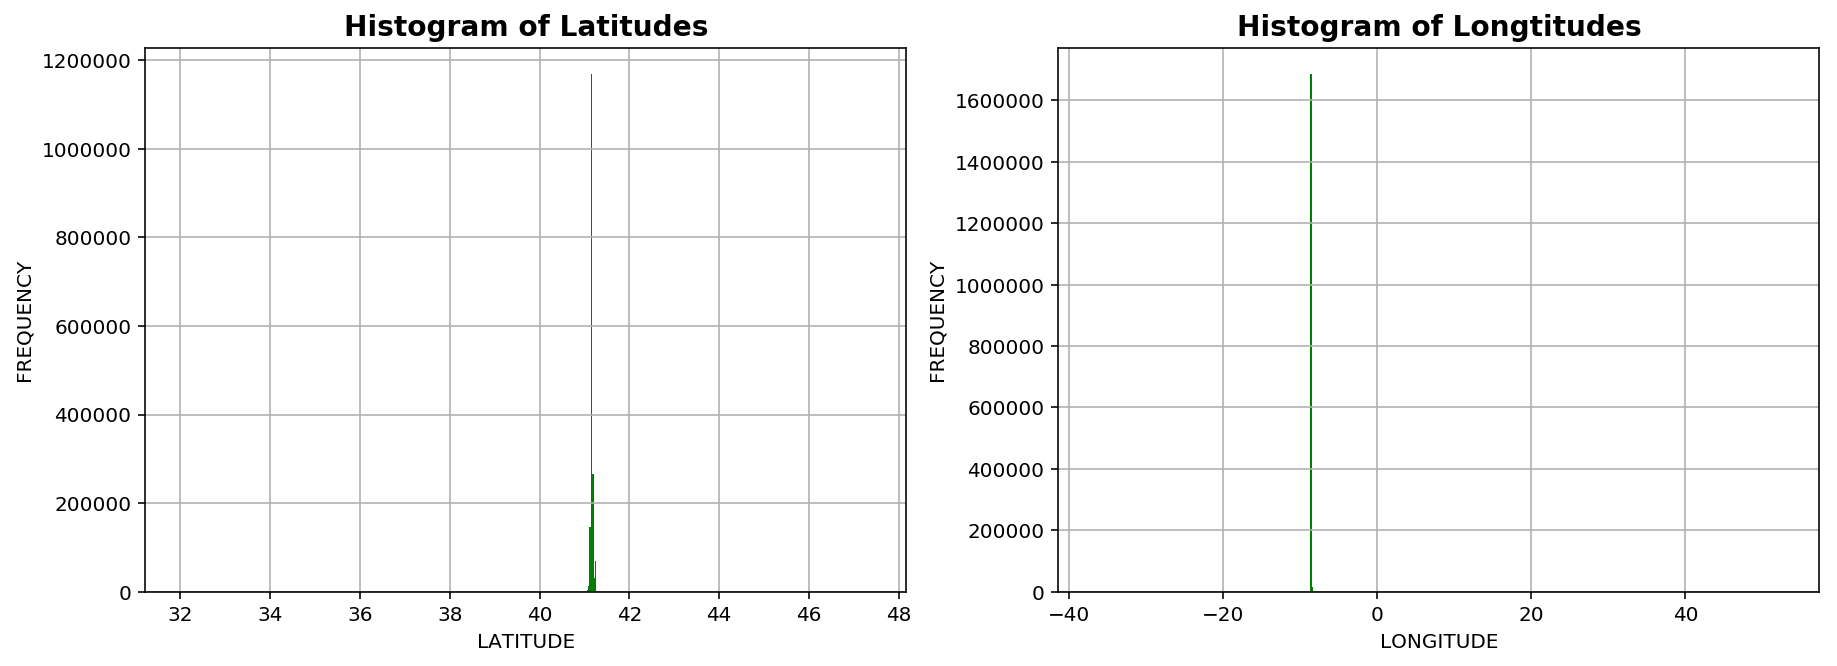

In [5]:
f,ax = plt.subplots(1,2,figsize=(15,5))

plt.subplot(121)
taxi["END_LAT"].hist(bins=500, facecolor='g')
plt.ylabel('FREQUENCY')
plt.xlabel('LATITUDE')
plt.title('Histogram of Latitudes',fontsize=14, fontweight='bold')

plt.subplot(122)
taxi["END_LONG"].hist(bins=500, facecolor='g')
plt.ylabel('FREQUENCY')
plt.xlabel('LONGITUDE')
plt.title('Histogram of Longtitudes', fontsize=14, fontweight='bold')



#seems relatively normal distributed

In order to better visualise on the outliers, the destinations are plotted out (Lattitude agasint Longtitudes) on a 2d histogram along with boxplots of both latitudes and longtitudes. 

From the plots of the destination coordinates we can clearly see that most trip destinations end around a certain region as most points are concentrated into a small blob. However, there are a few trips which end way very far off. 

From the scatter plots, there appears to many suspected outliers (1.5×IQR or more above the third quartile or 1.5×IQR or more below the first quartile). 

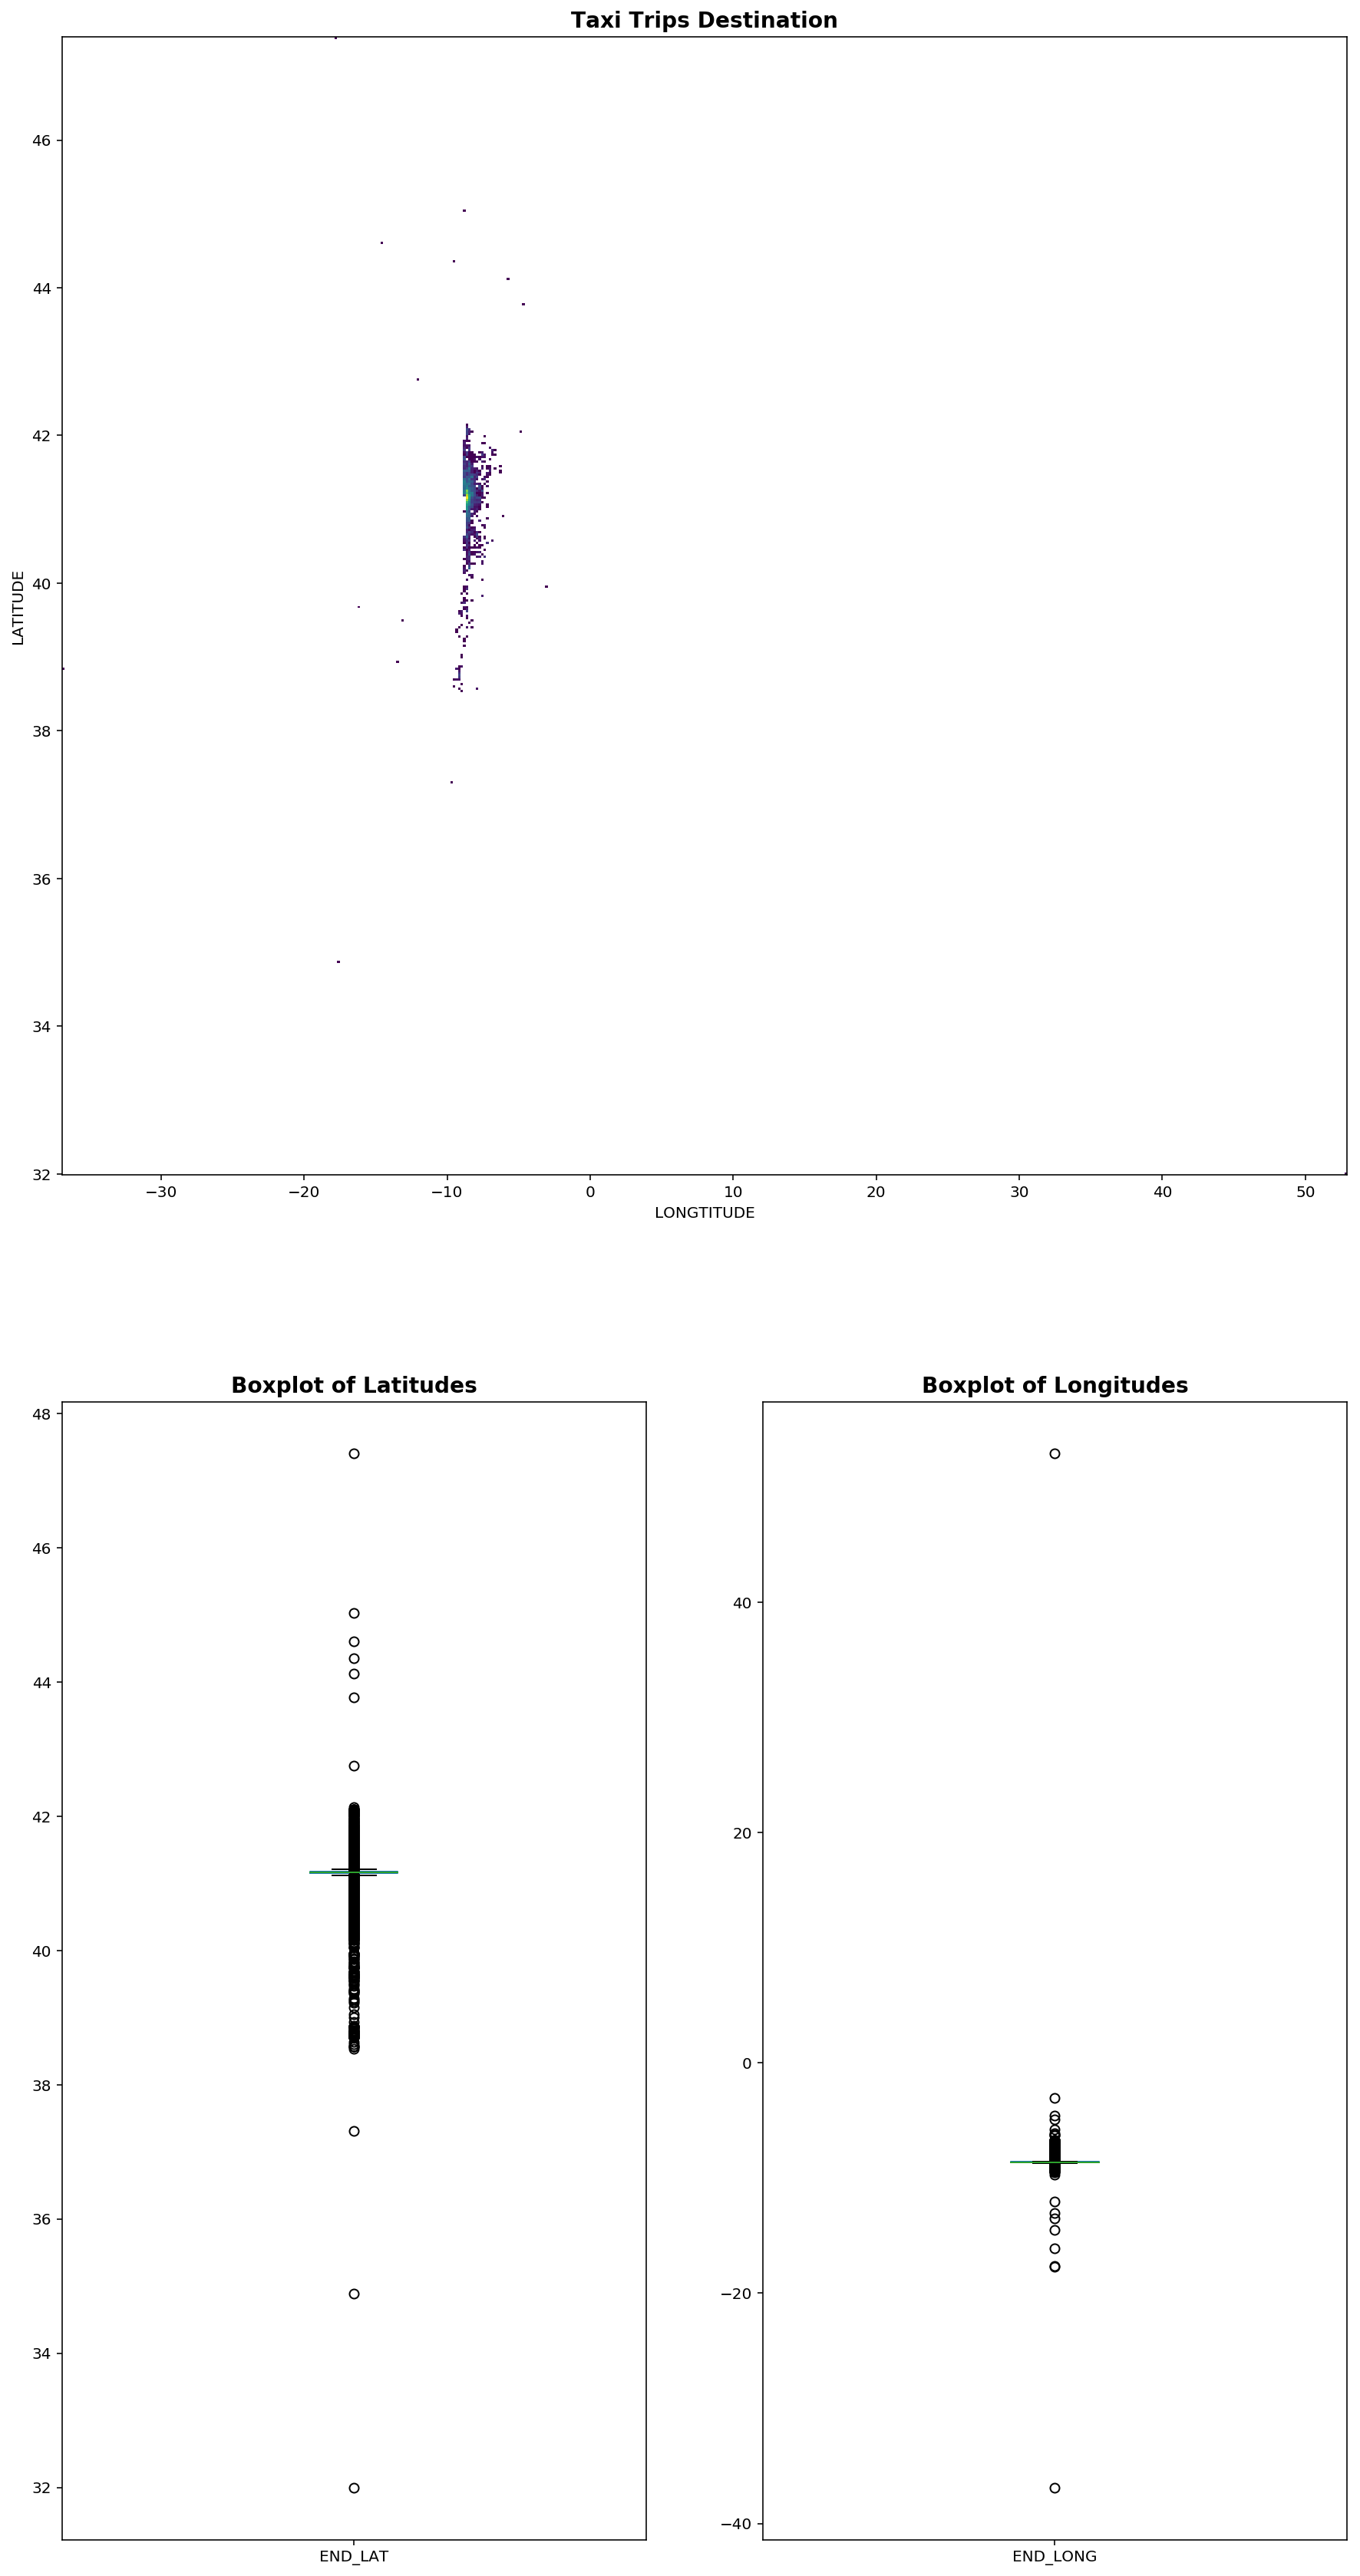

In [6]:
range = [[taxi['END_LONG'].min(), taxi['END_LONG'].max()],
    [taxi['END_LAT'].min(), taxi['END_LAT'].max()]] #setting the range both x-axis & y-axis with the min and max value accordingly


f,ax = plt.subplots(2,2,figsize=(15,30))
plt.subplot(211)
plt.hist2d(taxi['END_LONG'], taxi['END_LAT'], bins=500, norm=LogNorm(), range=range)
plt.ylabel('LATITUDE')
plt.xlabel('LONGTITUDE')
plt.title('Taxi Trips Destination', fontsize=14, fontweight='bold')

plt.subplot(223)
taxi['END_LAT'].plot(kind='box')
plt.title('Boxplot of Latitudes', fontsize=14, fontweight='bold')

plt.subplot(224)
taxi['END_LONG'].plot(kind='box')
plt.title('Boxplot of Longitudes', fontsize=14, fontweight='bold')

plt.show()

As the are many suspected outliers, the usual 1.5×IQR from the quartile might not be a good way to determine outliers. Therefore, both the option of using 3×IQR from the quartile to determine outliers is considered. Both ranges will be compared to determine which is more suitable. 

In [7]:
#get_ranges() gets the 1.5×IQR from the 1st and 3rd quartile
def get_ranges(df,col):
    """
    Getting the upper and lower limits of the a feature using 1.5*IQR
    """
    IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)
    lower = df[col].quantile(q=0.25) - 1.5*IQR
    upper = df[col].quantile(q=0.75) + 1.5*IQR
    return lower, upper

long_lower, long_upper = get_ranges(taxi,"END_LONG")
lat_lower, lat_upper = get_ranges(taxi,"END_LAT")

In [8]:
#get_ranges3() gets the 3×IQR from the 1st and 3rd quartile
def get_ranges3(df,col):
    """
    Getting the upper and lower limits of the a feature using 3*IQR
    """
    IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)
    lower = df[col].quantile(q=0.25) - 3*IQR
    upper = df[col].quantile(q=0.75) + 3*IQR
    return lower, upper

long_lower_3, long_upper_3 = get_ranges3(taxi,"END_LONG")
lat_lower_3, lat_upper_3 = get_ranges3(taxi,"END_LAT")

After getting both 1.5xIQR & 3xIQR, we will plot both destination plots to determine which is a better choice.

In [9]:
print lat_lower_3, long_lower_3, lat_upper_3, long_upper_3

41.082408 -8.754606 41.237073 -8.488809


Text(0.5,1,u'Taxi Trips Destination with 3xIQR')

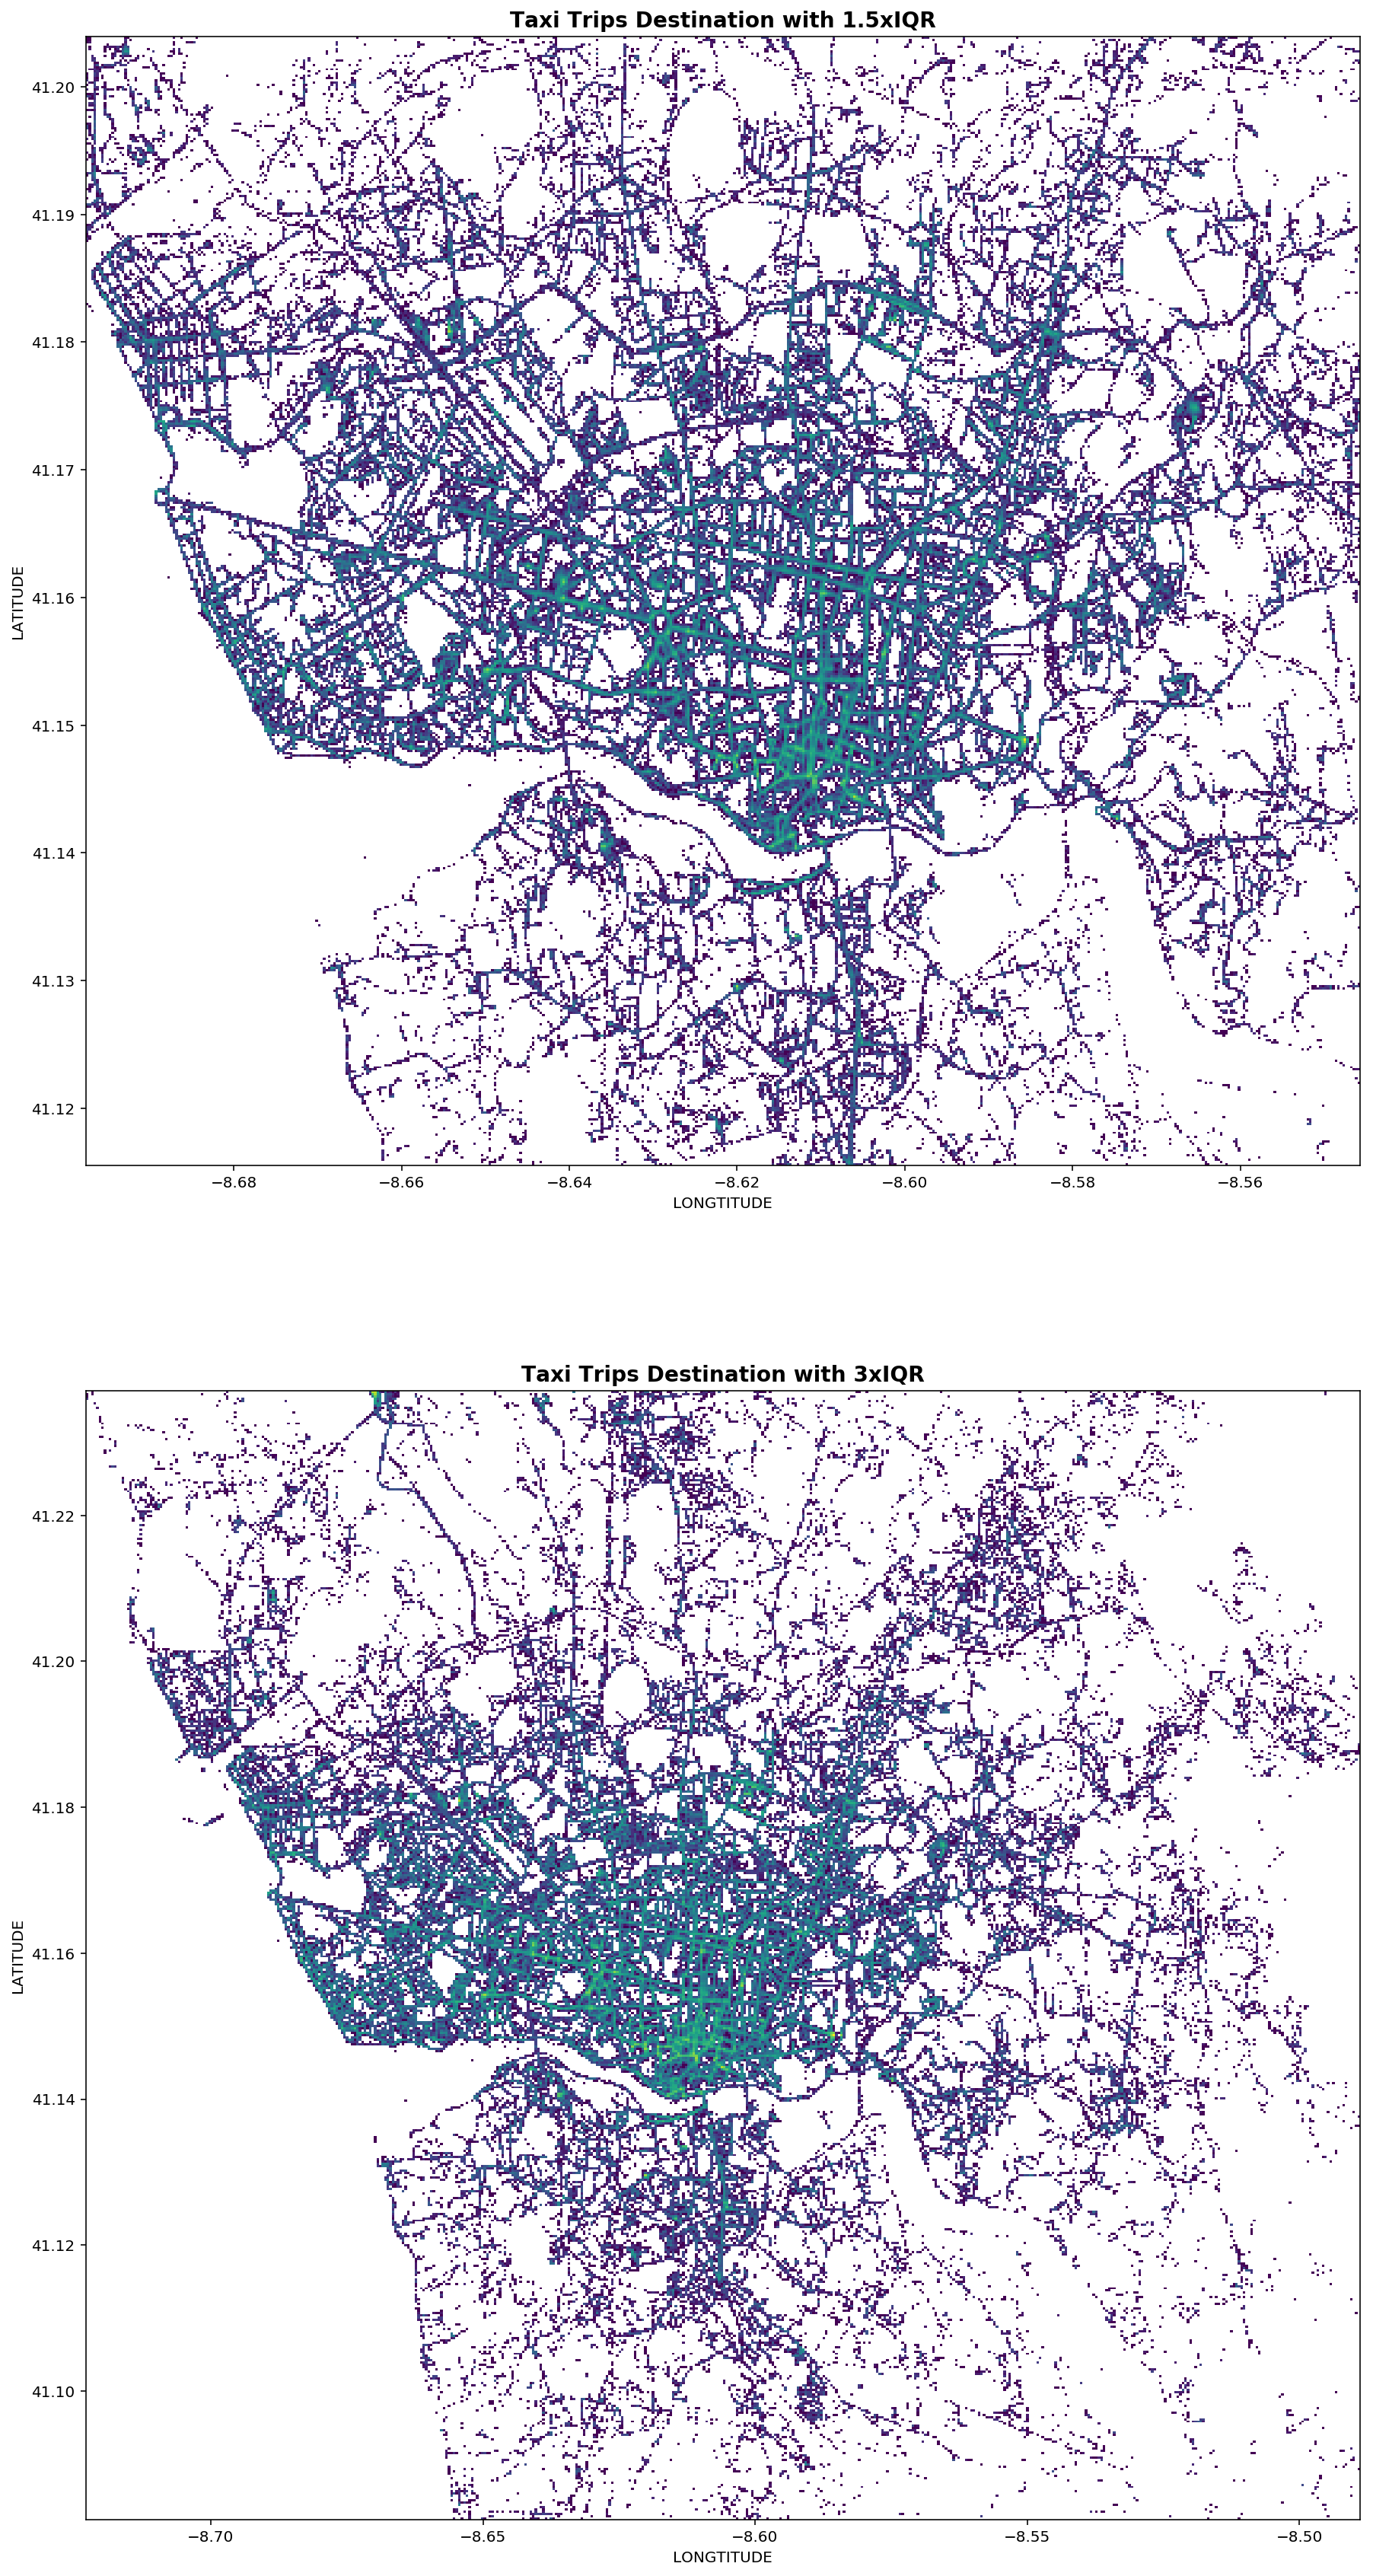

In [10]:
# clean_outliers removes outliers with the upper and lower limits derived from get_ranges()
def clean_outliers(df,col,lower,upper):
    """
    Removing outliers with the upper and lower limits derived from get_ranges()
    """
    return df[(df[col] > lower) & (df[col] < upper)]

# a refers to dataset with outliers removed using Q1/Q3 +- 1.5*IQR
# b refers to dataset with outliers removed using Q1/Q3 +- 3*IQR

a = taxi.copy()
b = taxi.copy()

a = clean_outliers(a,"END_LONG",long_lower, long_upper)
a = clean_outliers(a,"END_LAT",lat_lower, lat_upper)

b = clean_outliers(b,"END_LONG",long_lower_3, long_upper_3)
b = clean_outliers(b,"END_LAT",lat_lower_3, lat_upper_3)

range_a = [[a['END_LONG'].min(), a['END_LONG'].max()],
    [a['END_LAT'].min(), a['END_LAT'].max()]]
range_b = [[b['END_LONG'].min(), b['END_LONG'].max()],
    [b['END_LAT'].min(), b['END_LAT'].max()]]

f,ax = plt.subplots(2,2,figsize=(15,30))
plt.subplot(211)
plt.hist2d(a['END_LONG'], a['END_LAT'], bins=500, norm=LogNorm(), range=range_a)
plt.ylabel('LATITUDE')
plt.xlabel('LONGTITUDE')
plt.title('Taxi Trips Destination with 1.5xIQR', fontsize=14, fontweight='bold')

plt.subplot(212)
plt.hist2d(b['END_LONG'], b['END_LAT'], bins=500, norm=LogNorm(), range=range_b)
plt.ylabel('LATITUDE')
plt.xlabel('LONGTITUDE')
plt.title('Taxi Trips Destination with 3xIQR', fontsize=14, fontweight='bold')

Looking at both plots, it is observed that the points in green are the where most trips end. There is a high concentration of green points which seems to indicate that most trips end at the city centre. The plot with 1.5xIQR seems to a remove a fair bit of popular destinations after comparing the points at the left, top and bottom of both plots. Therefore, 3xIQR is chosen to remove outliers.

Using https://geographiclib.sourceforge.io/cgi-bin/Planimeter?type=polygon&rhumb=rhumb&input=41.082408+-8.754606%0D%0A41.082408+-8.488809%0D%0A41.237073+-8.488809%0D%0A41.237073+-8.754606&option=Submit
the area calcuated within 3xIQR is 383.1899249km sq.

In [11]:
#Removing outliers using clean_outliers() with 3xIQR
taxi = clean_outliers(taxi,"END_LONG",long_lower_3, long_upper_3)
taxi = clean_outliers(taxi,"END_LAT",lat_lower_3, lat_upper_3)

Other than removing end points which end very far from the majority, the duration and distance of a trip is also looked at: 

In [12]:
taxi[taxi["DURATION"] == 0].shape  

(29906, 17)

29906 trips are found to have a duration of 0s. This would mean that in the 'POLYLINE', there is only set of coordinate logged. These are mostly trips where the taxi driver might have accidentally turn on the meter, therefore trips with only one set of coordinates will be removed. 

In [13]:
#dropping duration = 0s
taxi = taxi[taxi["DURATION"] != 0]

In addition, the distance of the trips is also examined. 349 trips started and end at the same point. Coordinates logged are up to sixth decimal places, which means it can accurately identify objects on the globe of up to 111.32 mm accuracy, therefore it indicates that the taxi is stationary for those 349 trips logged as it is almost impposible for a taxi to pick up a pax and return back to the exact the same point (+/-)111.32mm. Thus, trips with 0km distance will be removed.

In [14]:
print taxi[taxi["DISTANCE"] == 0].shape
print taxi[(taxi["START_LAT"] == taxi["END_LAT"]) & (taxi["START_LONG"] == taxi["END_LONG"])].shape

(349, 17)
(349, 17)


In [15]:
taxi = taxi[taxi["DISTANCE"] != 0] #removing trips where start and end points are exactly the same

Generally distance travelled is portionally related to duration taken, a regplot is used to visualise this. 

Text(0.5,1,u'Distance VS Duration')

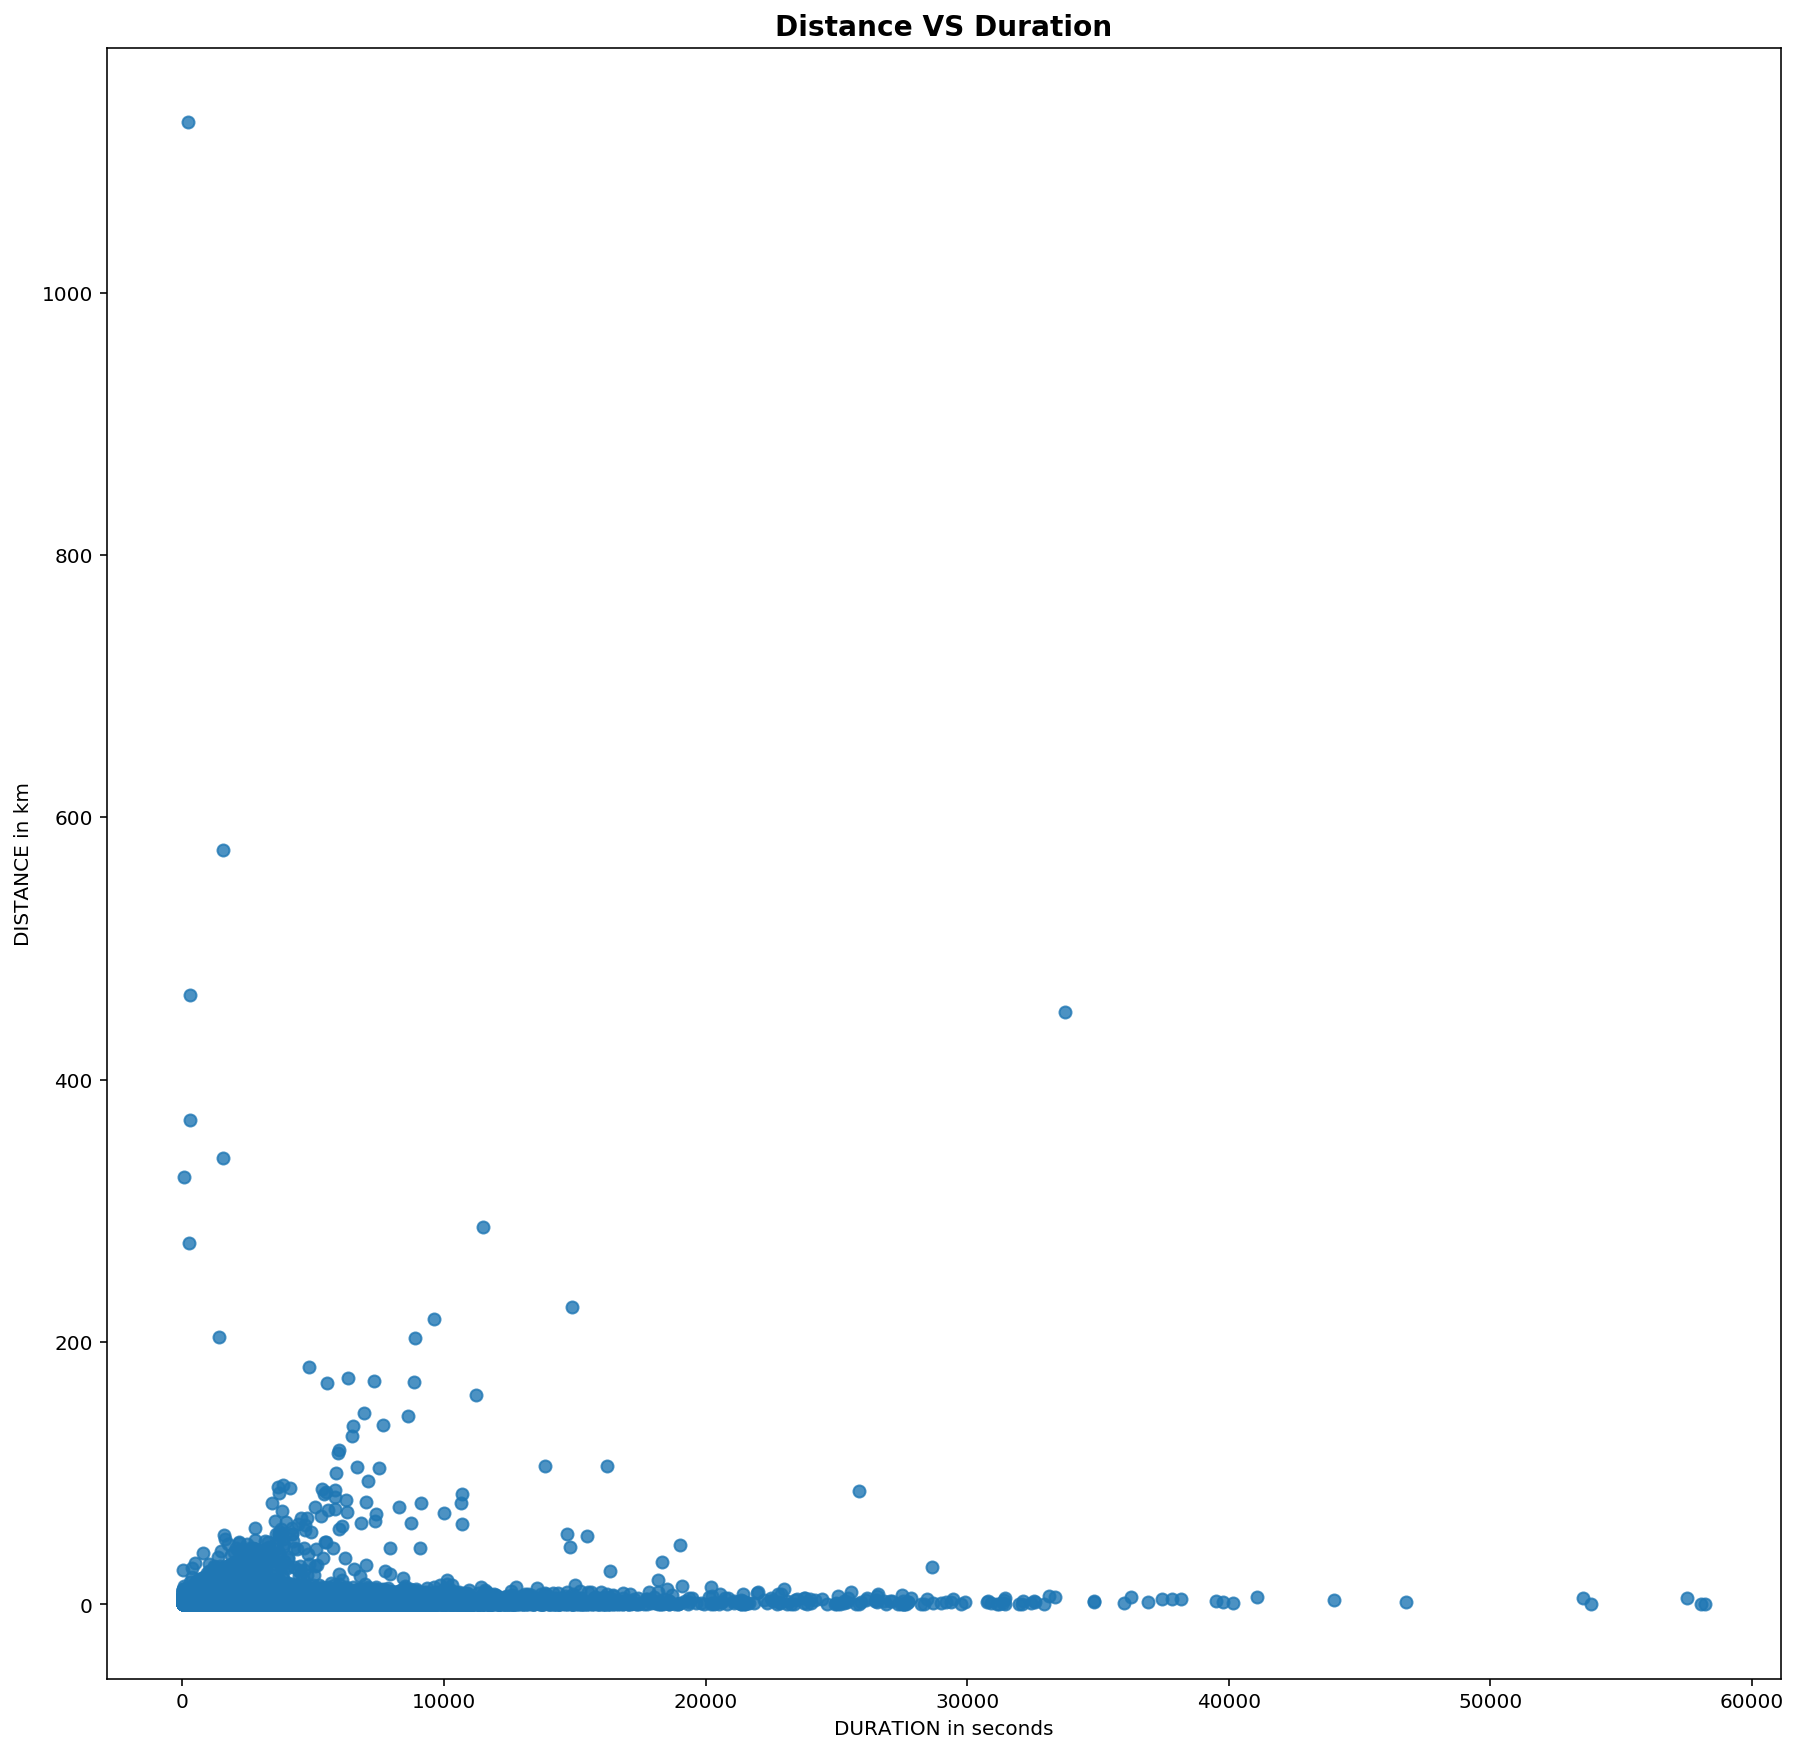

In [16]:
f, ax = plt.subplots(figsize=(15,15))
sns.regplot(taxi["DURATION"],taxi['DISTANCE'],fit_reg=False)
plt.ylabel('DISTANCE in km')
plt.xlabel('DURATION in seconds')
plt.title('Distance VS Duration', fontsize=14, fontweight='bold')

Looking at the regression line in the plot above it seems that there is little relationship between both distance and durtion. This could be explained as taxis do not travel in a straight path and there are also plently of turns being made when travelling in a city.

However, on the left hand side of the plot, there are trips which covered a long distance over a short period of time, over 1100km in under 3hours and on the right hand side of the plot, trips which took a long time to complete but only covered a short distance are observed, trips with duration of over 10hours but travelled less than 10km.

In order to removed the noise identified, the distribtion of both distance and duration will be observed and their after a using the boxplot, similar to how outliers for the destinations are identified and removed will be carried out. 

Text(0.5,1,u'Histogram of DURATION')

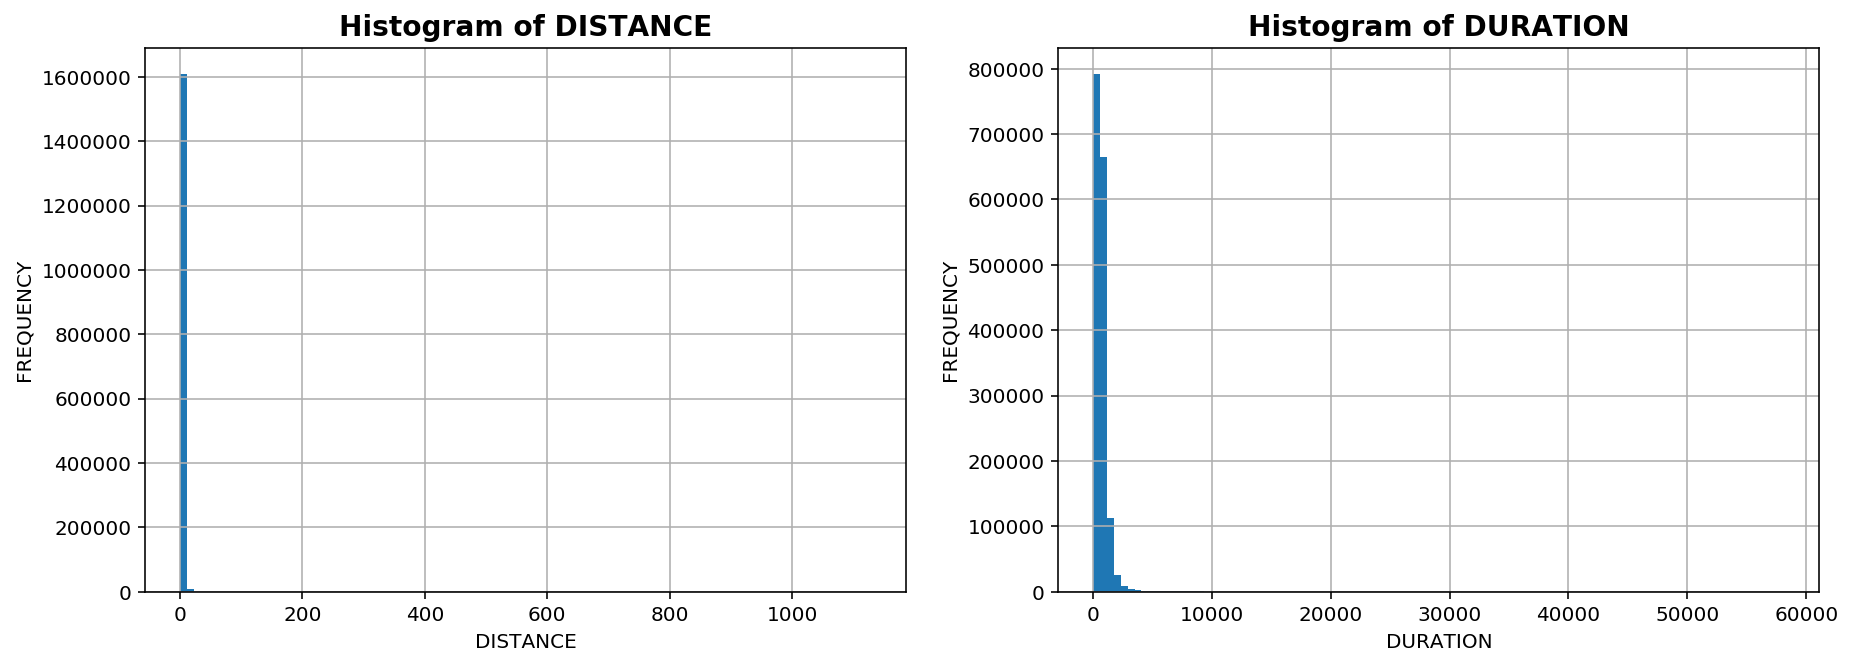

In [17]:
f,ax = plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
taxi["DISTANCE"].hist(bins=100)
plt.ylabel('FREQUENCY')
plt.xlabel('DISTANCE')
plt.title('Histogram of DISTANCE', fontsize=14, fontweight='bold')

plt.subplot(122)
taxi["DURATION"].hist(bins=100)
plt.ylabel('FREQUENCY')
plt.xlabel('DURATION')
plt.title('Histogram of DURATION', fontsize=14, fontweight='bold')

As the distribution of the duration and distance is very right skewed. Normalisation techniques are applied to decide on outliers.

Text(0.5,1,u'Histogram of DURATION')

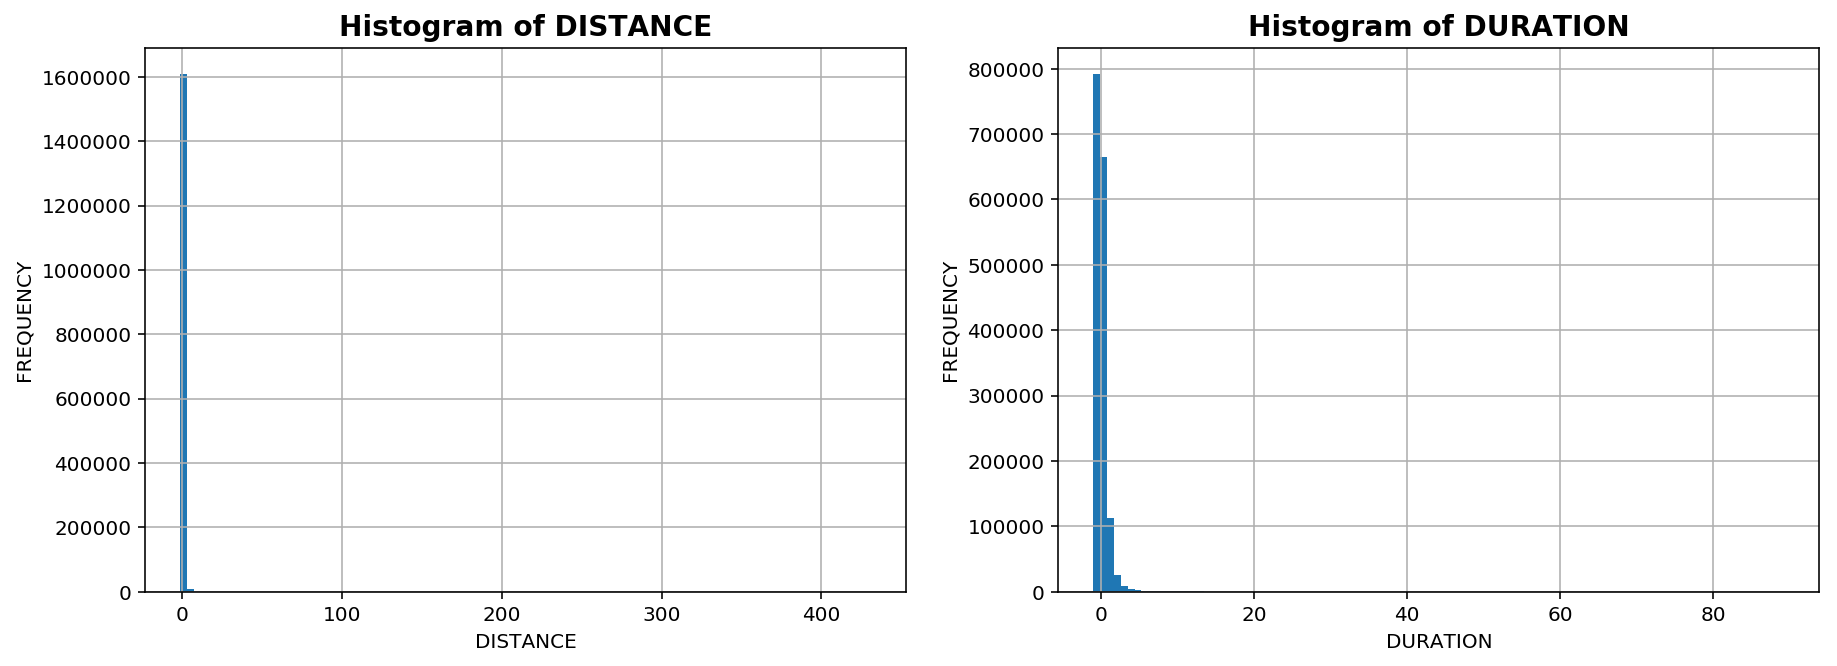

In [18]:
# subtracting mean over std as a form of normalisation
DIS = (taxi["DISTANCE"] - taxi["DISTANCE"].mean())/(taxi["DISTANCE"].std())
DUR = (taxi["DURATION"] - taxi["DURATION"].mean())/(taxi["DURATION"].std())

f,ax = plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
DIS.hist(bins=100)
plt.ylabel('FREQUENCY')
plt.xlabel('DISTANCE')
plt.title('Histogram of DISTANCE', fontsize=14, fontweight='bold')

plt.subplot(122)
DUR.hist(bins=100)
plt.ylabel('FREQUENCY')
plt.xlabel('DURATION')
plt.title('Histogram of DURATION', fontsize=14, fontweight='bold')

It seems that the outliers are too extreme that by subtracting the mean/std did not help to normalise the distributions. Therefore, we will try taking a log of the duration & distance as it will dampen the effect of points at the extreme ends.

In [19]:
# taking log to dampen the effect of points at the extreme ends
taxi['DURATION_LOG'] = taxi['DURATION'].map(lambda x : np.log(x))
taxi['DISTANCE_LOG'] = taxi['DISTANCE'].map(lambda x : np.log(x))

Text(0.5,1,u'Histogram of DURATION_LOG')

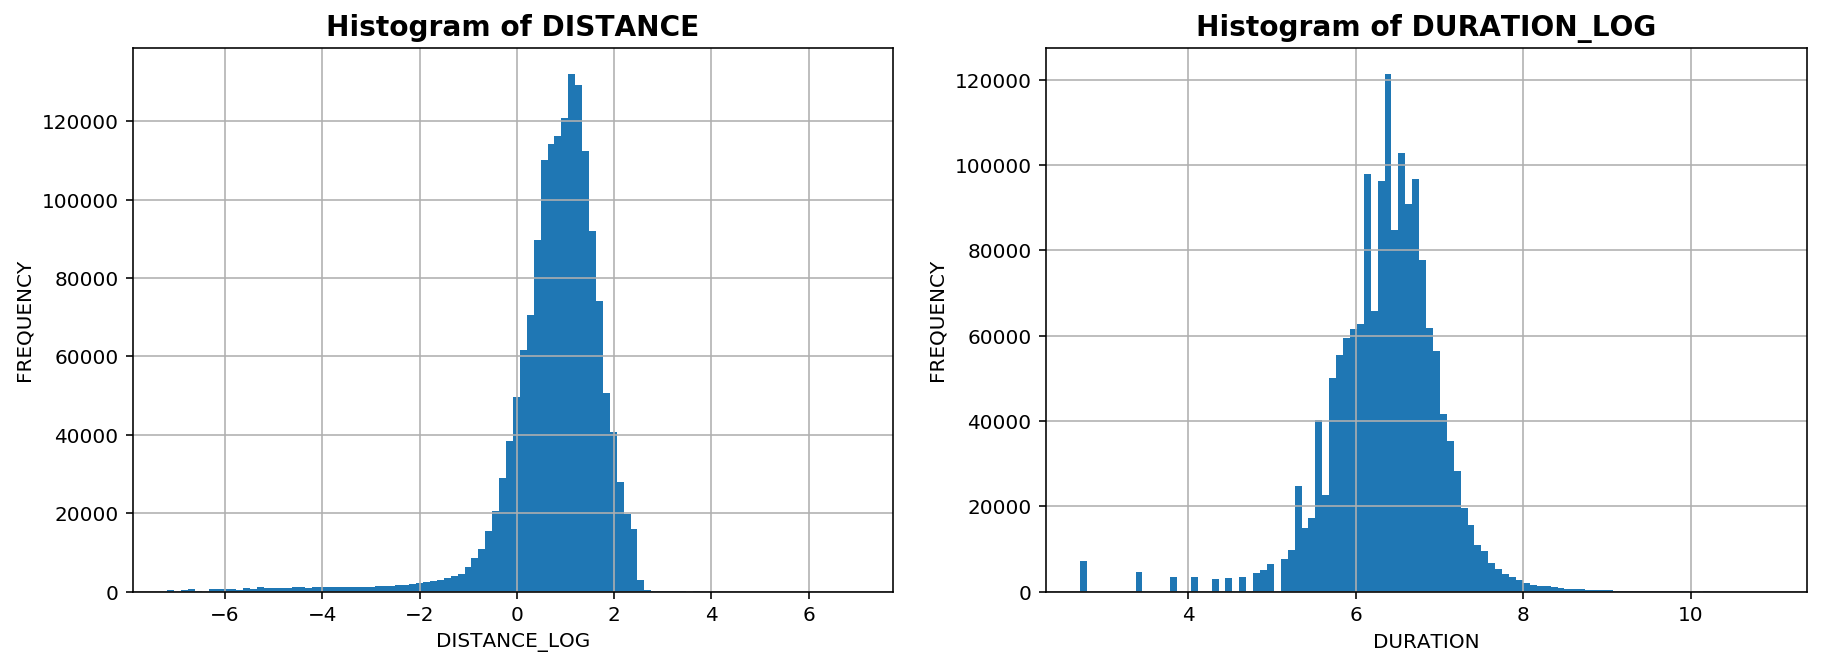

In [20]:
f,ax = plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
taxi["DISTANCE_LOG"].hist(bins=100)
plt.ylabel('FREQUENCY')
plt.xlabel('DISTANCE_LOG')
plt.title('Histogram of DISTANCE', fontsize=14, fontweight='bold')

plt.subplot(122)
taxi["DURATION_LOG"].hist(bins=100)
plt.ylabel('FREQUENCY')
plt.xlabel('DURATION')
plt.title('Histogram of DURATION_LOG', fontsize=14, fontweight='bold')

As both "DURATION_LOG" & "DISTANCE_LOG" and follows a seemingly normal distribution, boxplots can be used to determine outliers.

Text(0.5,1,u'Boxplot of DURATION_LOG')

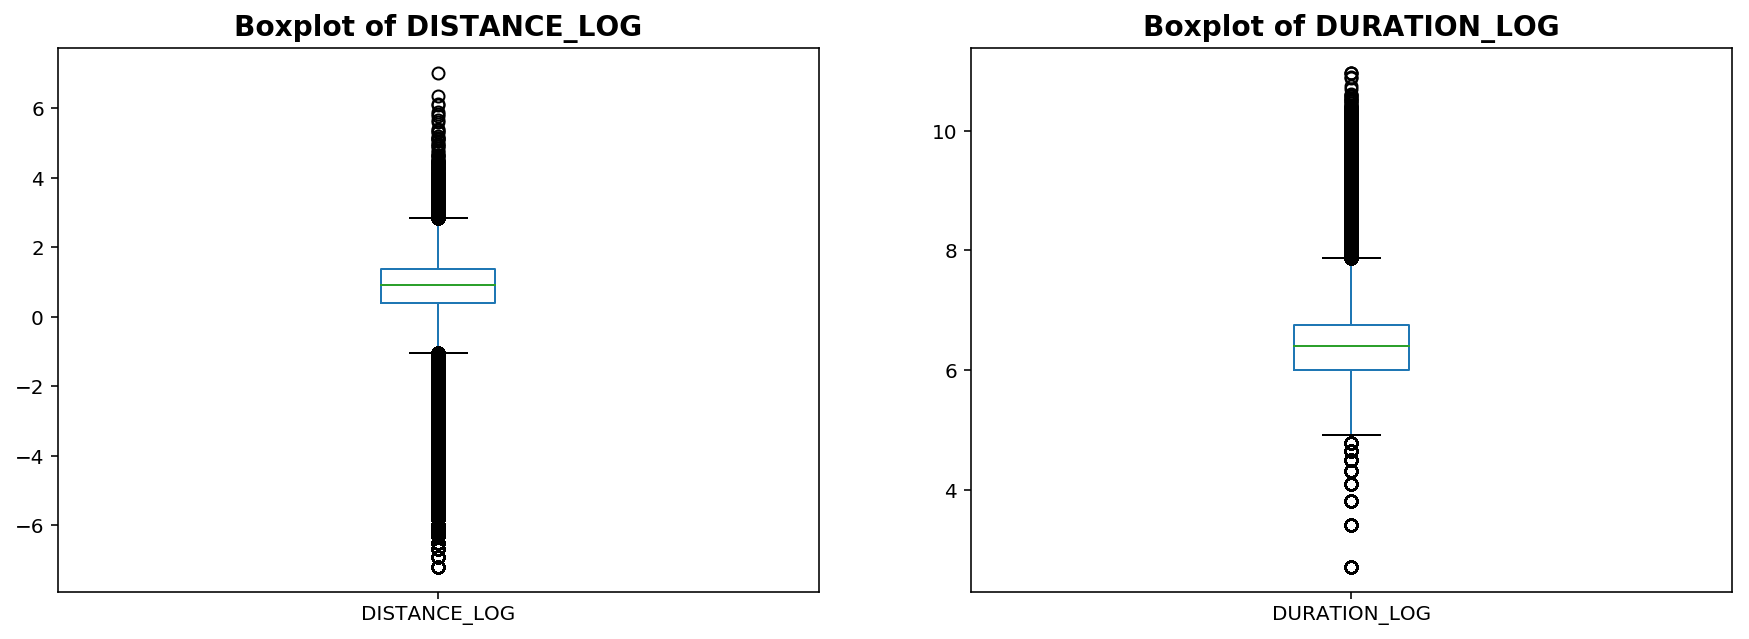

In [21]:
f,ax = plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
taxi["DISTANCE_LOG"].plot(kind='box')
plt.title('Boxplot of DISTANCE_LOG', fontsize=14, fontweight='bold')

plt.subplot(122)
taxi["DURATION_LOG"].plot(kind='box')
plt.title('Boxplot of DURATION_LOG', fontsize=14, fontweight='bold')

In [22]:
dur_log_lower, dur_log_upper = get_ranges(taxi,"DURATION_LOG")
dur_log_lower3, dur_log_upper3 = get_ranges3(taxi,"DURATION_LOG")

dis_log_lower, dis_log_upper = get_ranges(taxi,"DISTANCE_LOG")
dis_log_lower3, dis_log_upper3 = get_ranges3(taxi,"DISTANCE_LOG")

print "Range of duration lower, upper limits with 1.5*IQR:" 
print str(np.exp(dur_log_lower)) + 's , ' + str(np.exp(dur_log_upper)) + 's'
print ""
print "Range of duration lower, upper limits with 3*IQR:" 
print str(np.exp(dur_log_lower3)) + 's , ' + str(np.exp(dur_log_upper3)) + 's'
print "---------------------------------------------------------"
print "Range of distance lower, upper limits with 1.5*IQR:" 
print str(np.exp(dis_log_lower)) + 'km , ' + str(np.exp(dis_log_upper)) + 'km'
print ""
print "Range of distance lower, upper limits with 3*IQR:" 
print str(np.exp(dis_log_lower3)) + 'km , ' + str(np.exp(dis_log_upper3)) + 'km'

Range of duration lower, upper limits with 1.5*IQR:
132.034792099s , 2622.6041977s

Range of duration lower, upper limits with 3*IQR:
43.044904505s , 8044.50617284s
---------------------------------------------------------
Range of distance lower, upper limits with 1.5*IQR:
0.351176925075km , 17.0283097615km

Range of distance lower, upper limits with 3*IQR:
0.0819235725792km , 72.9942466252km


Looking at the both ranges above, using 1.5xIQR for trips' distance and duration will introduce a large amount of bais as the distance of the taxi trips will be range between to 300m - 15km and durations between ~2mins to ~40mins. Whereas by using 3*IQR, the distance of the taxi trips will be range between 0.08 - 60.8km and durations between ~45s to ~2h. Taking into considering the area of end points is ~383km sq, 3xIQR would be a better choice to remove outliers. 

In [23]:
#Removing outliers using 3xIQR
taxi = clean_outliers(taxi,"DURATION_LOG",dur_log_lower3, dur_log_upper3)
taxi = clean_outliers(taxi,"DISTANCE_LOG",dis_log_lower3, dis_log_upper3)

Text(0.5,1,u'Distance VS Duration (Outliers Removed)')

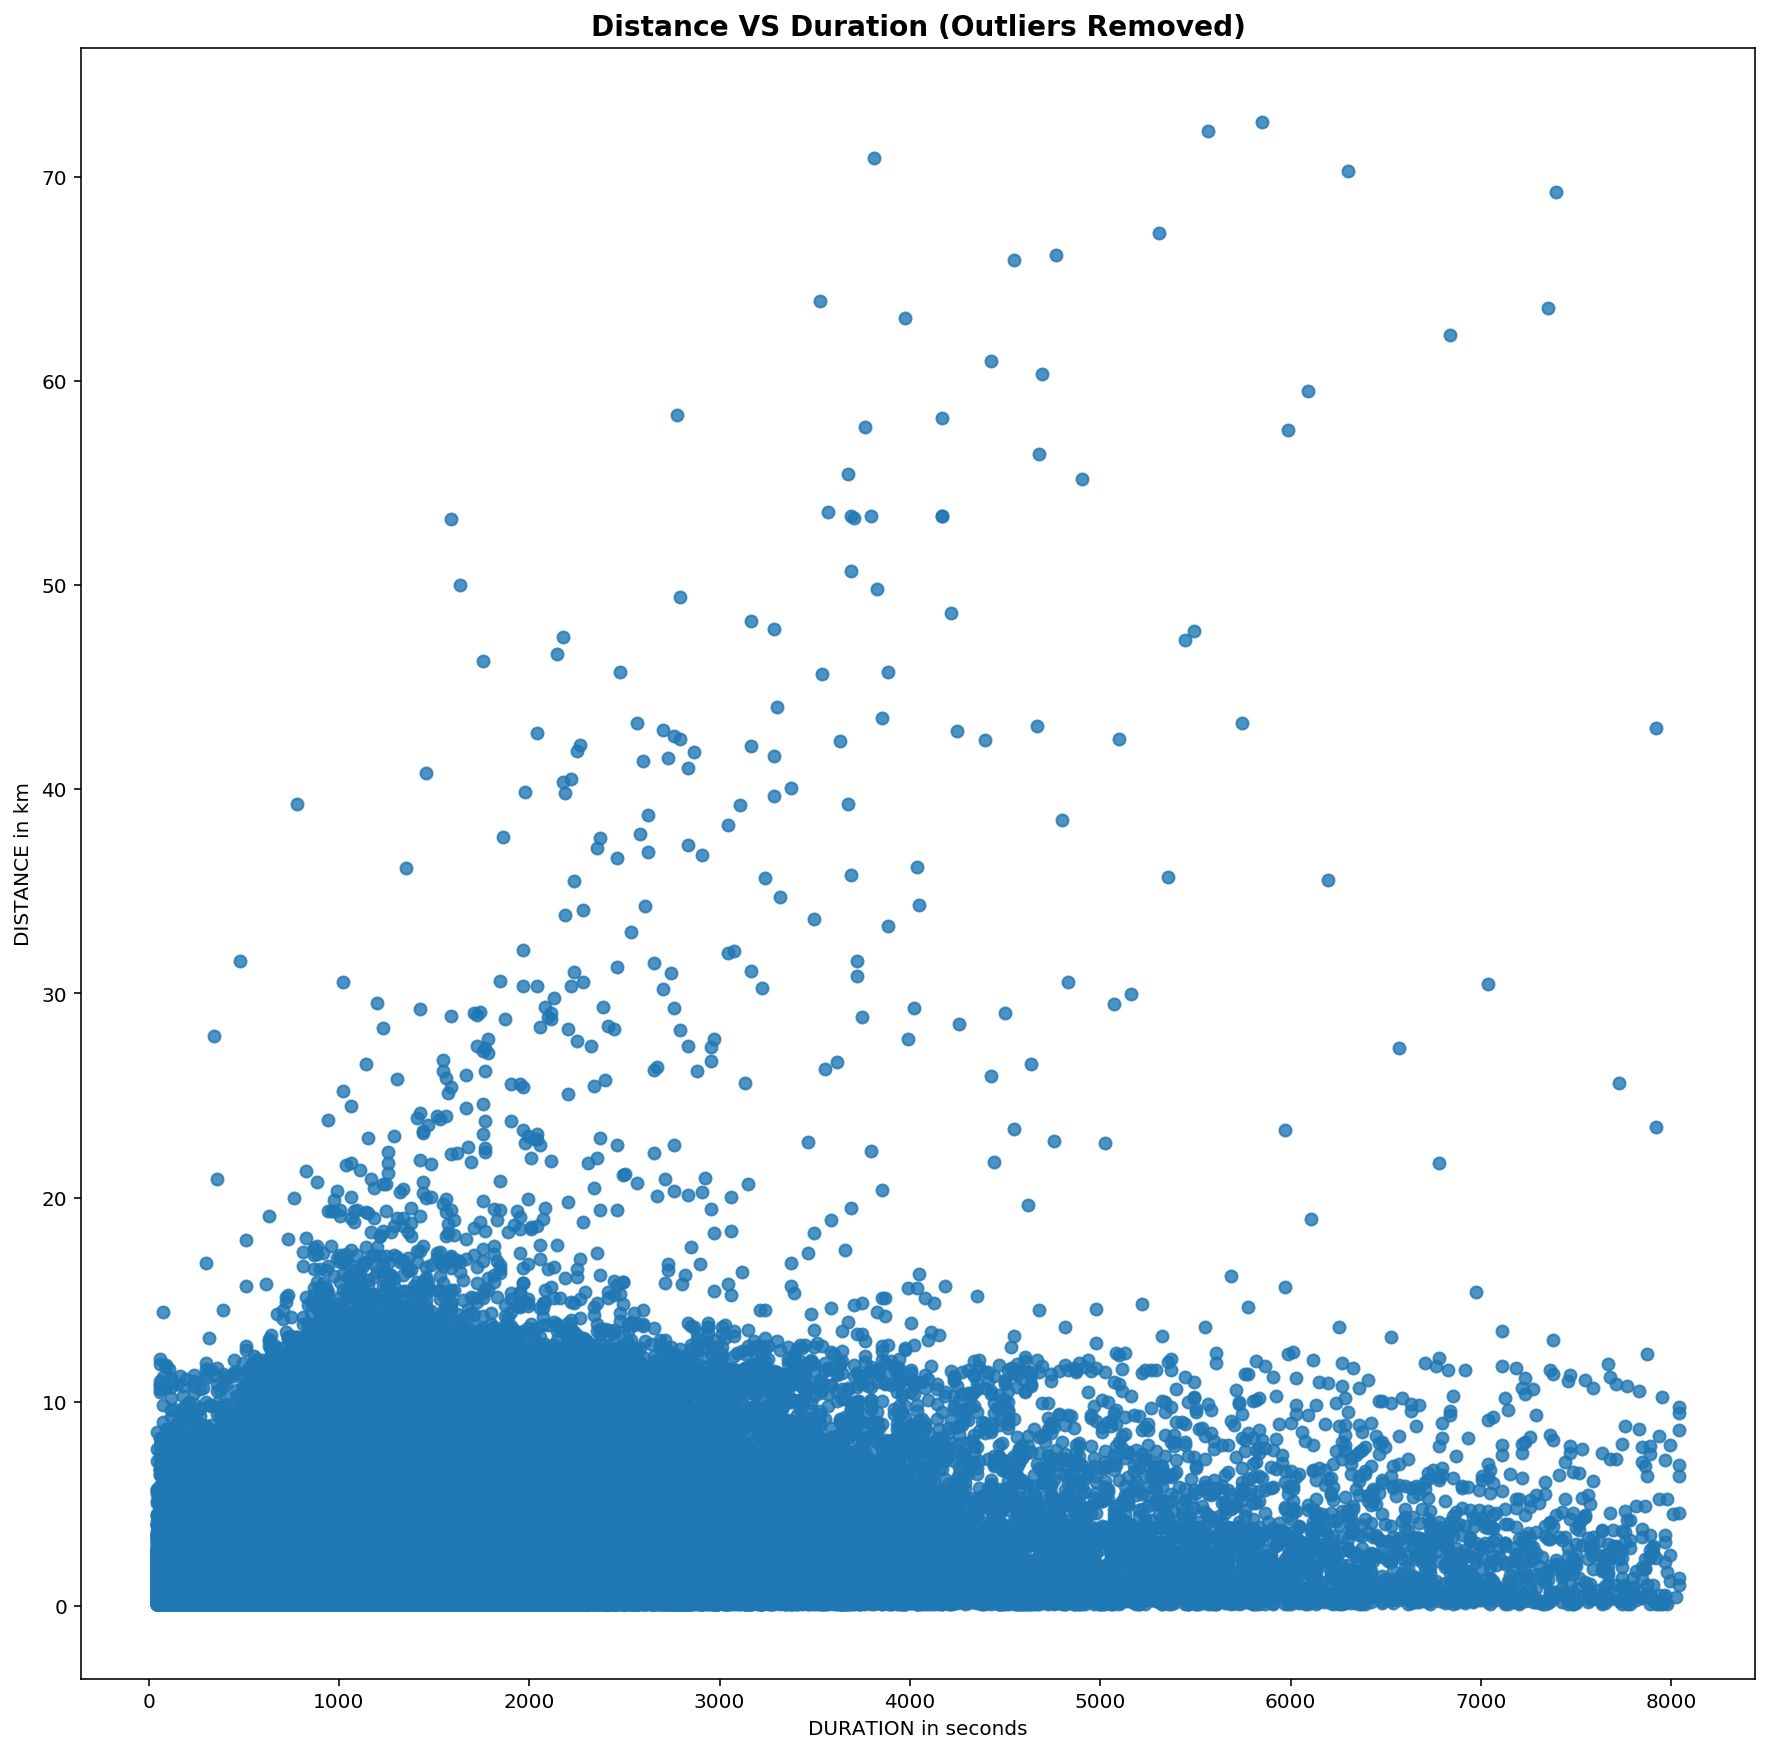

In [24]:
f, ax = plt.subplots(figsize=(15,15))
sns.regplot(taxi["DURATION"],taxi['DISTANCE'],fit_reg=False)
plt.ylabel('DISTANCE in km')
plt.xlabel('DURATION in seconds')
plt.title('Distance VS Duration (Outliers Removed)', fontsize=14, fontweight='bold')

After removing outliers, the plot seems more or less reasonable. 

In [25]:
taxi.shape

(1582557, 19)

## Gaining insights about the taxi trips between 01/07/2013 to 30/06/2014

Text(0.5,1,u'Frquency of trips start per quarter hour ')

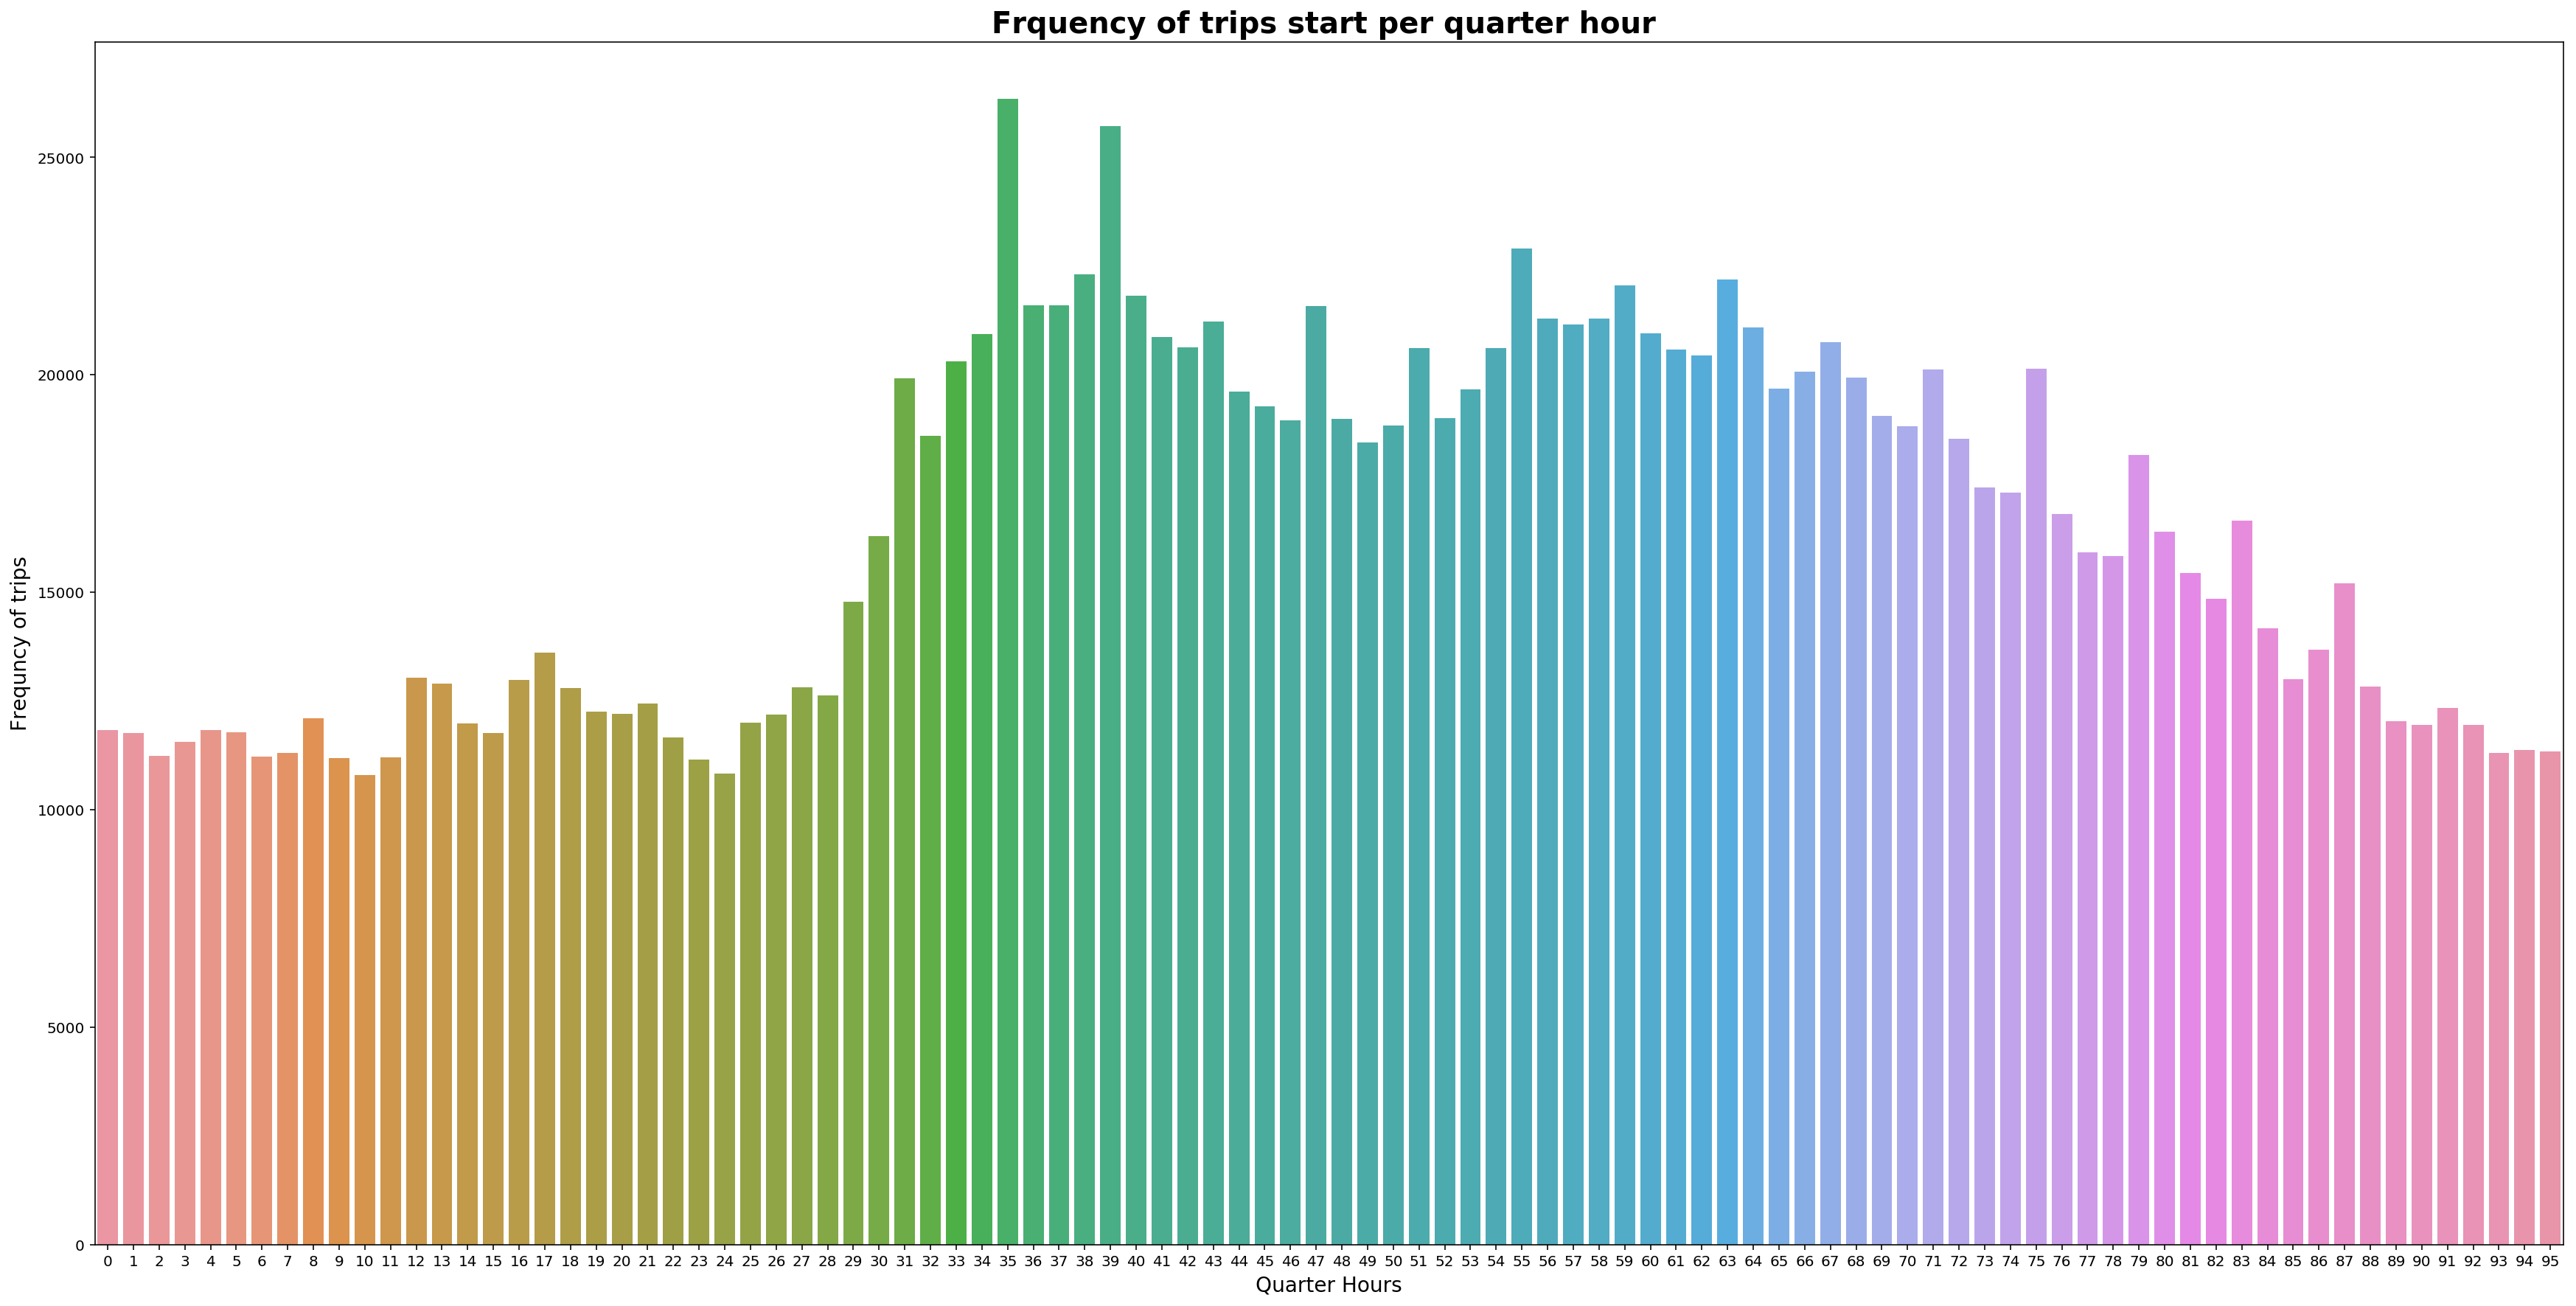

In [26]:
f, ax = plt.subplots(figsize=(30,15))
ax = sns.countplot(x="Q_HOUR", data=taxi, saturation=0.75)
plt.ylabel('Frequncy of trips', fontsize=14)
plt.xlabel('Quarter Hours', fontsize=14)
plt.title('Frquency of trips start per quarter hour ', fontsize=20, fontweight='bold')

Most taxi rides appears to happen between the day, 31 - 84 quarter hours, which is ~0800 - 2100 hours.
The quarter hour at which most trips are conducted is 35 , between 0845 to 0900 might be due to people being late and getting a taxi to rush to work/school. 
The quarter hour at which most trips are conducted is 10 , between 0230 to 0245.

Text(0.5,1,u'Frquency of trips start across day of week')

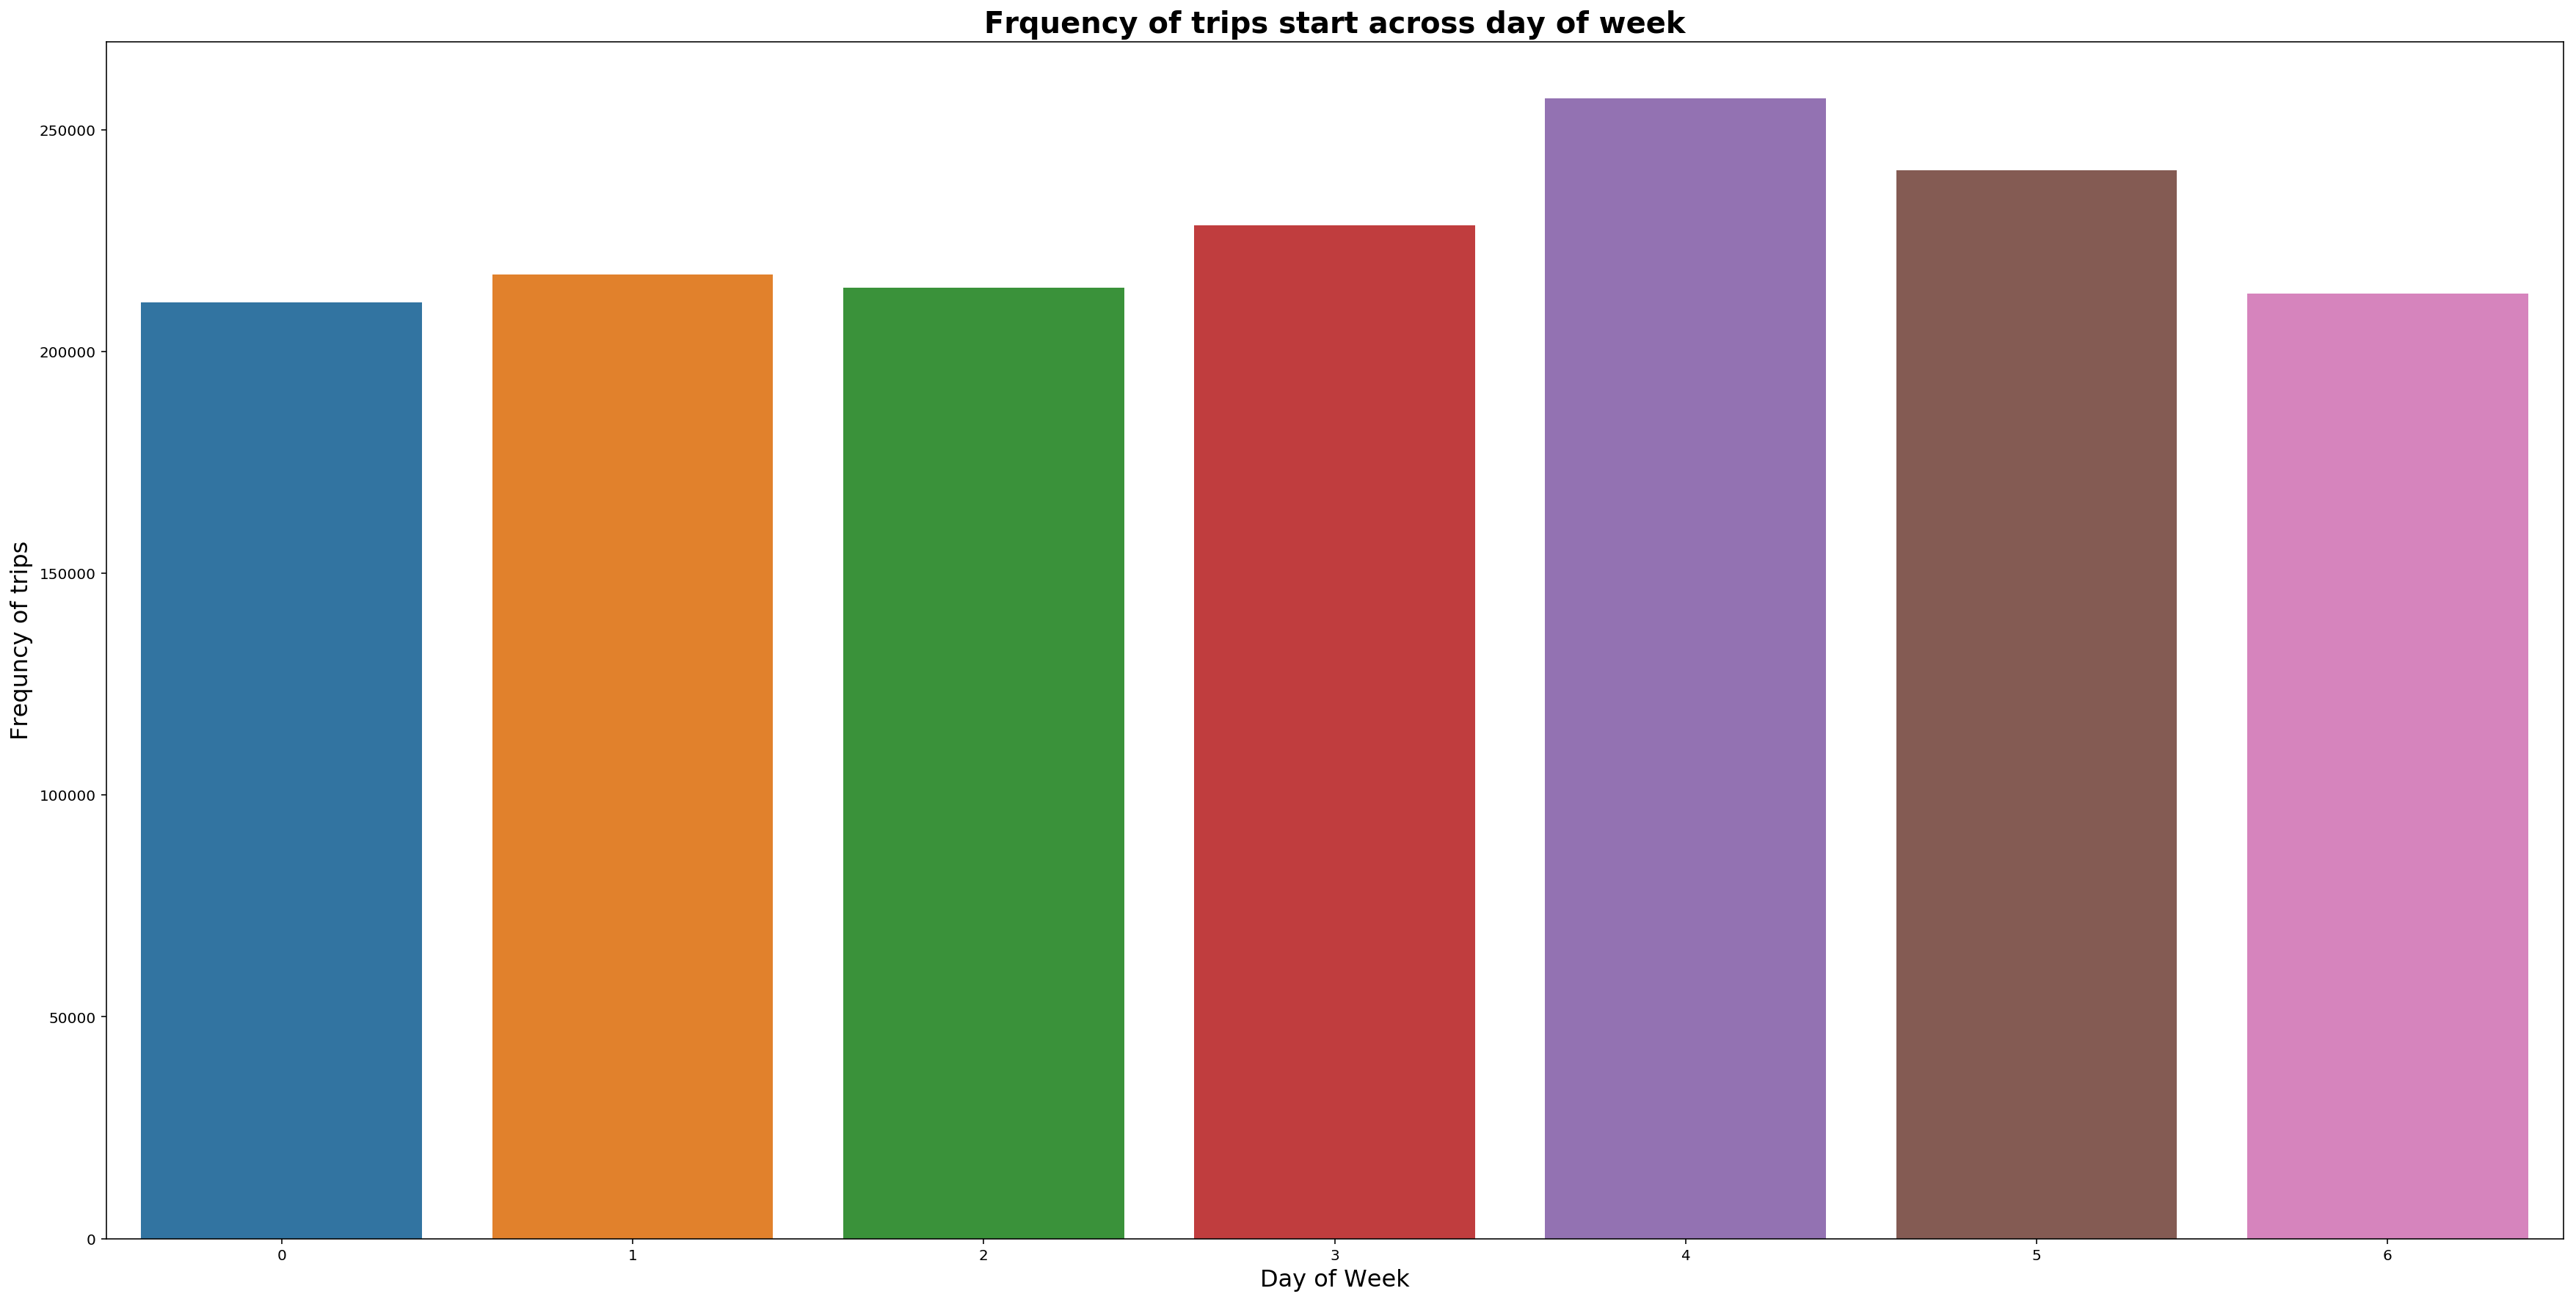

In [27]:
f, ax = plt.subplots(figsize=(30,15))
ax = sns.countplot(x="DAY", data=taxi, saturation=0.75)
plt.ylabel('Frequncy of trips',fontsize=16)
plt.xlabel('Day of Week', fontsize=16)
plt.title('Frquency of trips start across day of week', fontsize=20, fontweight='bold')

Note: {Monday to Sunday: 0 to 6}
There are slightly more taxi trips on Fridays and Saturdays. Most probably as white collar works who work office hours using a taxi to get to around.

Text(0.5,1,u'Frquency of trips start across week of year')

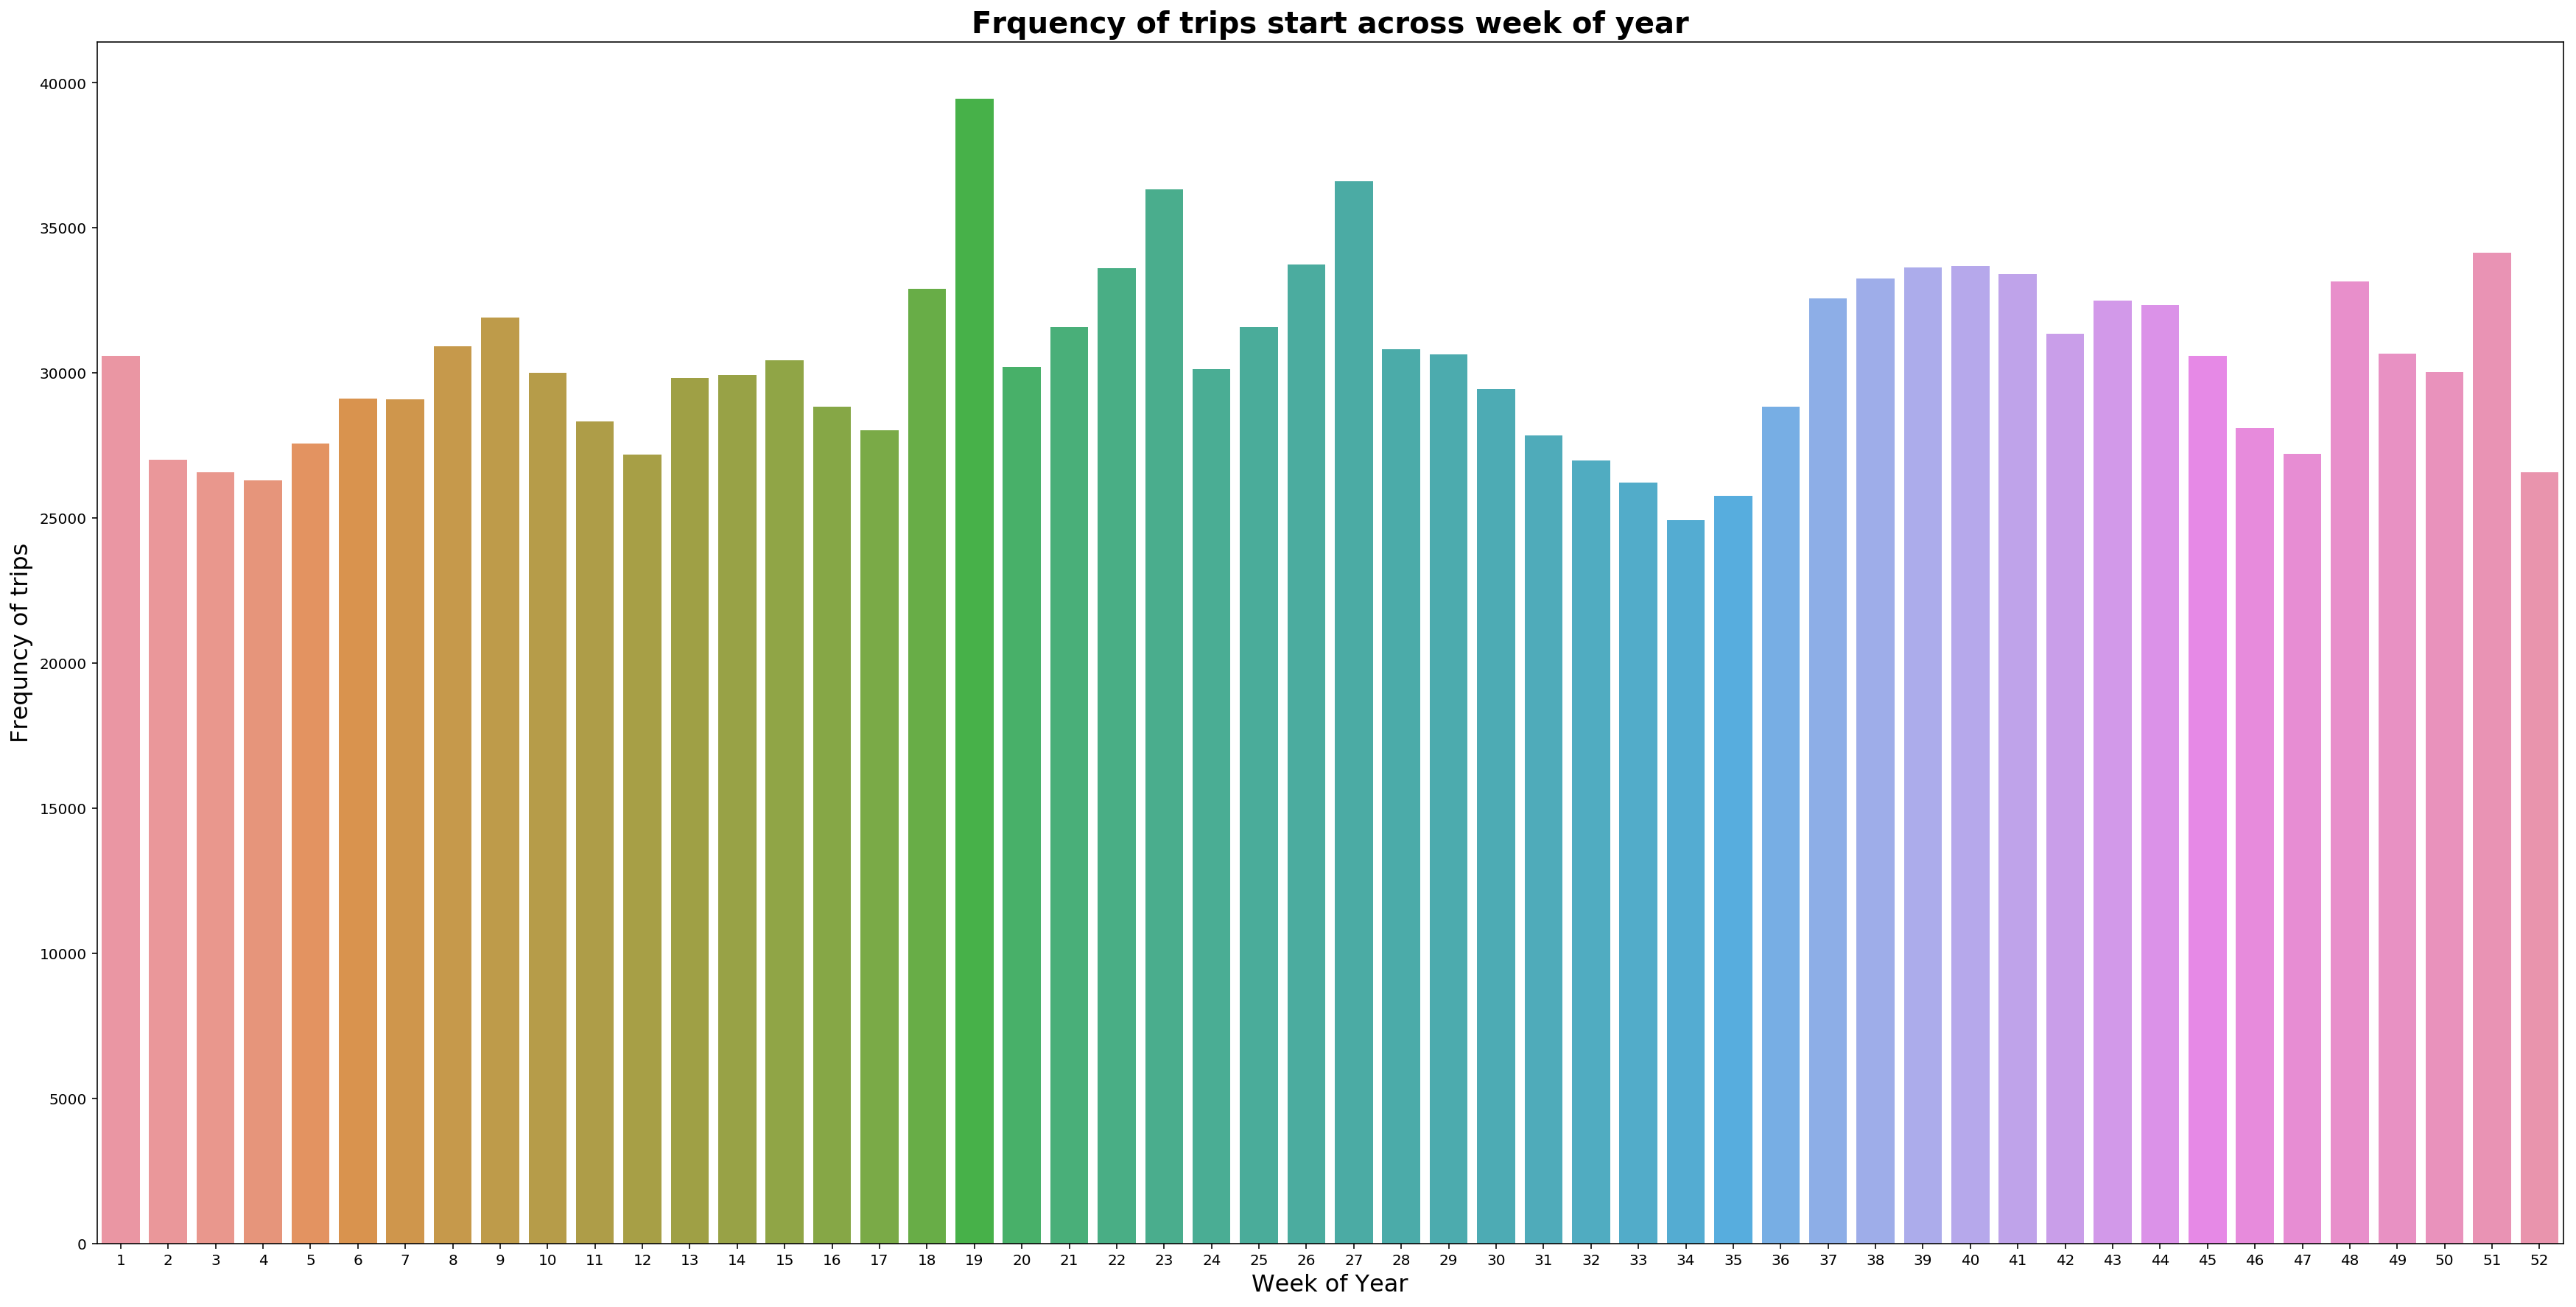

In [28]:
f, ax = plt.subplots(figsize=(30,15))
ax = sns.countplot(x="WEEK", data=taxi, saturation=0.75)
plt.ylabel('Frequncy of trips',fontsize=16)
plt.xlabel('Week of Year', fontsize=16)
plt.title('Frquency of trips start across week of year', fontsize=20, fontweight='bold')

There are appears to be a dip in taxi service August 2013, lowest being in week 34. From https://www.schoolholidayseurope.eu/portugal.html we understand that it is summer school holidays in Porto then, and it could be either taxi drivers or customers going on holidays. 

The peak of taxi trips is in last week of April 2014, which is Spring in Porto. 

In [29]:
print taxi["CALL_TYPE"].value_counts()[0]/float(taxi["CALL_TYPE"].shape[0])
print "~49% of trips are from taxi stands"
print "--------------------------------------"
print taxi["CALL_TYPE"].value_counts()[1]/float(taxi["CALL_TYPE"].shape[0])
print "~28% of trips are flagged off the road"
print "--------------------------------------"
print taxi["CALL_TYPE"].value_counts()[2]/float(taxi["CALL_TYPE"].shape[0])
print "~22% of trips are dispacthed"

0.492555402428
~49% of trips are from taxi stands
--------------------------------------
0.290611965319
~28% of trips are flagged off the road
--------------------------------------
0.216832632253
~22% of trips are dispacthed


Most of the trips started from a taxi stand (~49%)

Text(0.5,1,u'Frquency')

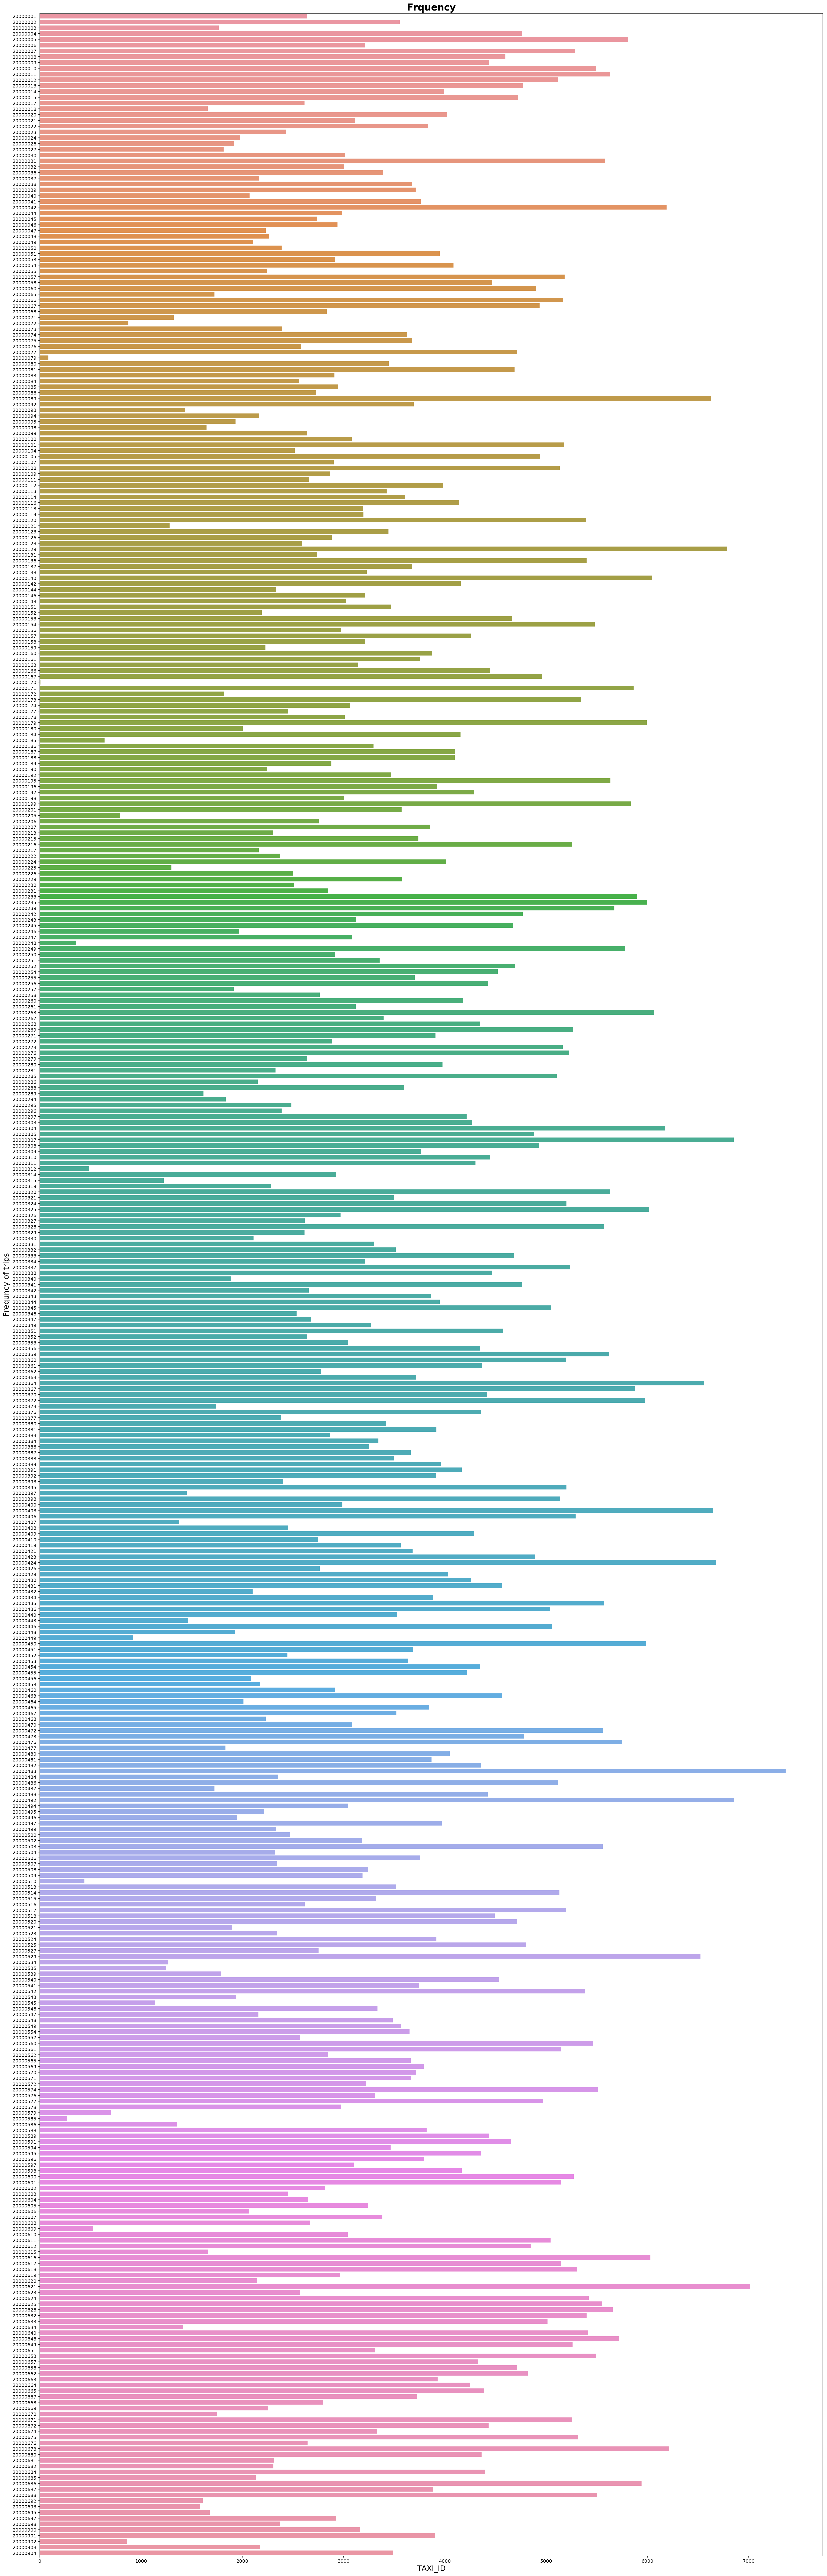

In [30]:
f, ax = plt.subplots(figsize=(30,100))
ax = sns.countplot(y="TAXI_ID", data=taxi, saturation=0.75)
plt.ylabel('Frequncy of trips',fontsize=16)
plt.xlabel('TAXI_ID', fontsize=16)
plt.title('Frquency', fontsize=20, fontweight='bold')

In [31]:
print taxi["TAXI_ID"].value_counts().iloc[0]/float(taxi.shape[0])*100  
print taxi["TAXI_ID"].value_counts(ascending=True).iloc[0]/float(taxi.shape[0])*100 

0.46538608088
0.000442322140688


0.46% of trips are carried out are carried out by taxi ID: 20000483  
0.000442% of trips are carried out by taxi ID: 20000170

Text(0.5,1,u'Frquency')

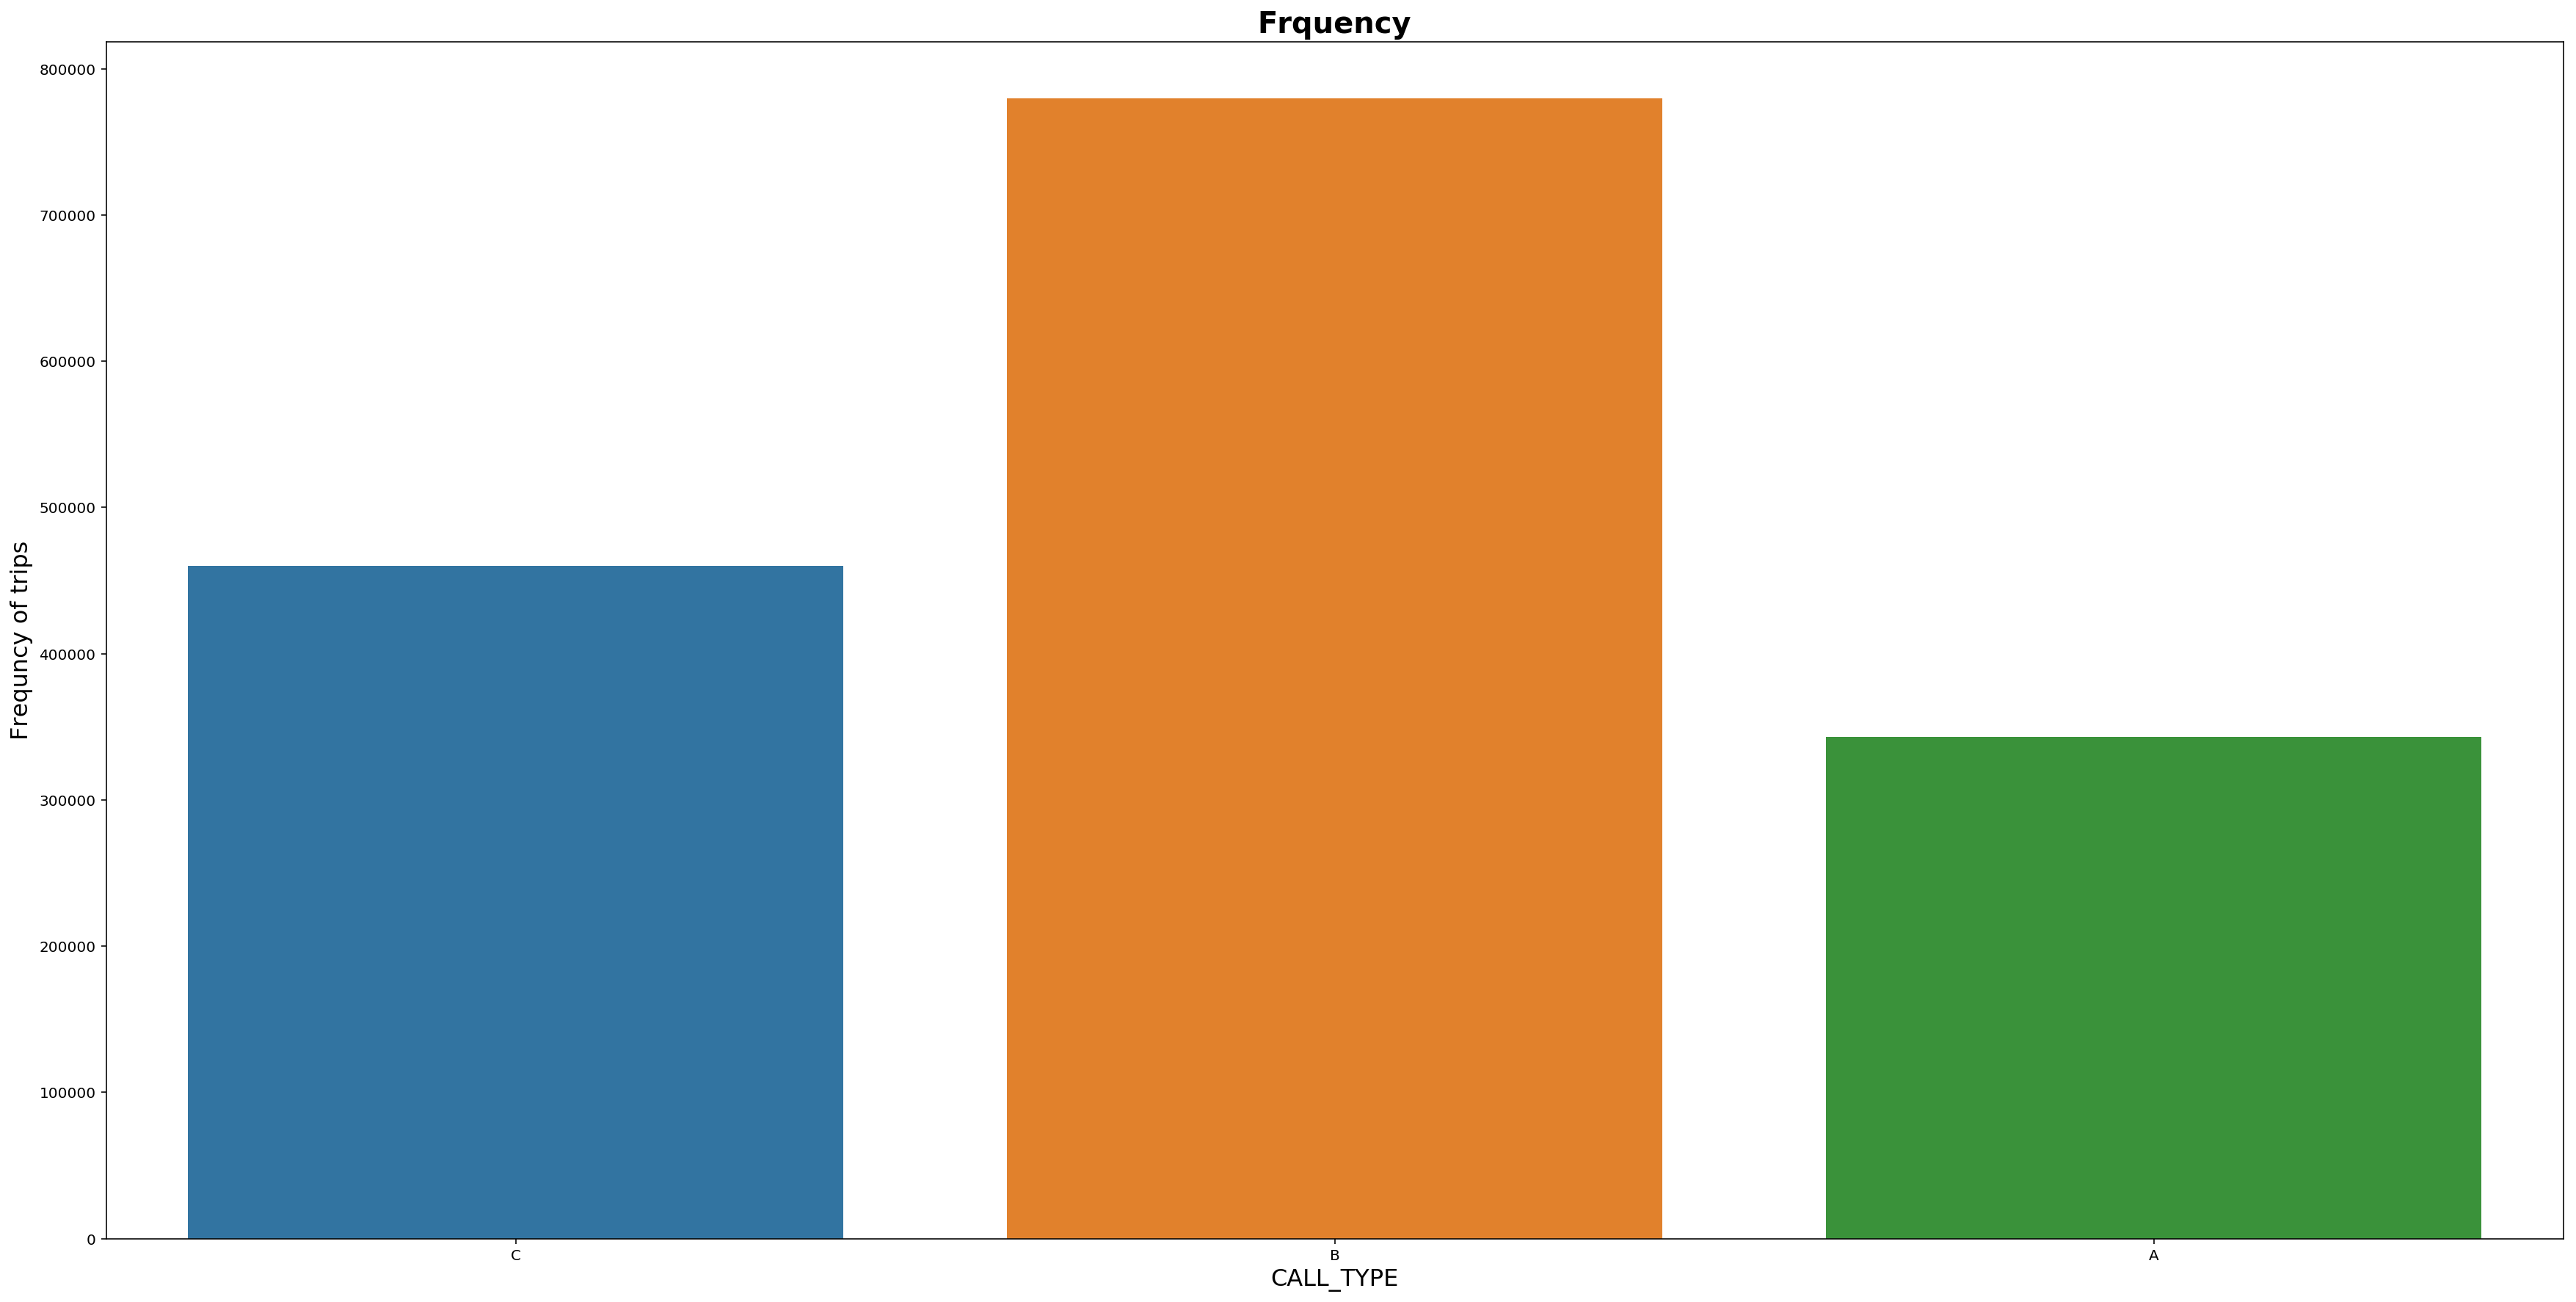

In [32]:
f, ax = plt.subplots(figsize=(30,15))
ax = sns.countplot(x="CALL_TYPE", data=taxi, saturation=0.75)
plt.ylabel('Frequncy of trips',fontsize=16)
plt.xlabel('CALL_TYPE', fontsize=16)
plt.title('Frquency', fontsize=20, fontweight='bold')

Both columns "ORIGIN_CALL" & "ORIGIN_STAND" are meant to provide more information if the "CALL_TYPE" is 'A' or 'B' respectively. A sanity check on both columns is conducted to ensure this before further analysis.

Earlier in the cleaning process, all NaN values have been replaced with 0, therefore:
- if "CALL_TYPE" is 'A' then "ORIGIN_CALL" should not be equal 0
- if "CALL_TYPE" is 'B' then "ORIGIN_CALL" should not be equal 0

In [33]:
taxi[(taxi["CALL_TYPE"] == 'A') & (taxi["ORIGIN_CALL"] == 0.0)]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE,START_LAT,START_LONG,END_LAT,END_LONG,date_time,WEEK,DAY,Q_HOUR,DISTANCE,DURATION,DURATION_LOG,DISTANCE_LOG


From above, when "CALL_TYPE" is 'A', there is no 0 values in "ORIGIN_CALL". This indicates that there is no missing information in "ORIGIN_CALL".

In [34]:
print taxi[(taxi["CALL_TYPE"] == 'B') & (taxi["ORIGIN_STAND"] == 0.0)].shape
taxi[(taxi["CALL_TYPE"] == 'B') & (taxi["ORIGIN_STAND"] == 0.0)]

(10581, 19)


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE,START_LAT,START_LONG,END_LAT,END_LONG,date_time,WEEK,DAY,Q_HOUR,DISTANCE,DURATION,DURATION_LOG,DISTANCE_LOG
136,1372638560620000308,B,0.0,0.0,20000308,1372638560,"[(41.148567, -8.58564), (41.148873, -8.585667)...",41.148567,-8.585640,41.189499,-8.576586,2013-07-01 00:29:20,27,0,1,4.614095,630,6.445720,1.529116
280,1372650696620000320,B,0.0,0.0,20000320,1372650696,"[(41.153517, -8.6058), (41.153472, -8.606133),...",41.153517,-8.605800,41.148963,-8.586729,2013-07-01 03:51:36,27,0,15,1.675129,285,5.652489,0.515890
433,1372656129620000307,B,0.0,0.0,20000307,1372656129,"[(41.154714, -8.63064), (41.154102, -8.630685)...",41.154714,-8.630640,41.232276,-8.661150,2013-07-01 05:22:09,27,0,21,8.994394,1005,6.912743,2.196602
564,1372665032620000004,B,0.0,0.0,20000004,1372665032,"[(41.156181, -8.591319), (41.156217, -8.591463...",41.156181,-8.591319,41.148819,-8.585649,2013-07-01 07:50:32,27,0,31,0.946306,330,5.799093,-0.055189
640,1372663170620000391,B,0.0,0.0,20000391,1372663170,"[(41.154966, -8.630712), (41.154867, -8.630775...",41.154966,-8.630712,41.148972,-8.585793,2013-07-01 07:19:30,27,0,29,3.819494,855,6.751101,1.340118
886,1372668256620000304,B,0.0,0.0,20000304,1372668256,"[(41.149143, -8.599266), (41.149143, -8.599266...",41.149143,-8.599266,41.150889,-8.622954,2013-07-01 08:44:16,27,0,34,1.992842,600,6.396930,0.689562
1287,1372668878620000605,B,0.0,0.0,20000605,1372668878,"[(41.154264, -8.649486), (41.154453, -8.649594...",41.154264,-8.649486,41.233959,-8.666163,2013-07-01 08:54:38,27,0,35,8.970870,1920,7.560080,2.193983
1352,1372672096620000027,B,0.0,0.0,20000027,1372672096,"[(41.144526, -8.606457), (41.144562, -8.606583...",41.144526,-8.606457,41.147550,-8.609310,2013-07-01 09:48:16,27,0,39,0.412475,285,5.652489,-0.885579
1387,1372672171620000684,B,0.0,0.0,20000684,1372672171,"[(41.182713, -8.600193), (41.182704, -8.599905...",41.182713,-8.600193,41.156172,-8.622927,2013-07-01 09:49:31,27,0,39,3.511529,660,6.492240,1.256052
1393,1372673132620000186,B,0.0,0.0,20000186,1372673132,"[(41.161446, -8.656893), (41.161887, -8.656083...",41.161446,-8.656893,41.157126,-8.630001,2013-07-01 10:05:32,27,0,40,2.301988,405,6.003887,0.833773


From above, when "CALL_TYPE" is 'B', there are no 10581 missing values in "ORIGIN_STAND". This indicates that there is no the "ORIGIN_STAND" is noisy. In addition, considering that, we already have the coordinates for the start of the trip, pick up at taxi stands should have approximately the same coordinates. Therefore,the "ORIGIN_STAND" column can be dropped.

In [35]:
taxi.drop("ORIGIN_STAND", axis=1, inplace=True)

In [36]:
taxi.reset_index(drop=True,inplace=True)

At this stage, the our dataset seems pretty much clean, therefore we shall conclude our EDA there. In addition to we will also have to load in our test data set to apply the changes we have done with our train dataset. 

In [3]:
test = pd.read_pickle('./Pickles/test_cleaned')

In [10]:
test["DISTANCE"] = haversine(test['START_LONG'],test['START_LAT'], test['END_LONG'], test['END_LAT'])
test["DURATION"] = duration(test)

def replace_zero(df,col,value=1):
    '''
    Changes 0 to 1 as log 0 is undefined
    '''
    df[col].replace(to_replace = 0, value = value, inplace = True)
    return df[col]

test["DURATION"] = replace_zero(test,"DURATION")
test["DISTANCE"] = replace_zero(test,"DISTANCE")

test['DURATION_LOG'] = test['DURATION'].map(lambda x : np.log(x))
test['DISTANCE_LOG'] = test['DISTANCE'].map(lambda x : np.log(x))

test.drop("ORIGIN_STAND", axis=1, inplace=True)

Saving both train and test files which we have completed EDA on to pickle files for Part 3 which is Capstone_Taxi_3-Train_Val_Test_Prep_Final.

In [11]:
taxi.to_pickle('./Pickles/test_EDA_completed')
test.to_pickle('./Pickles/test_EDA_completed')